# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(0)
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (0.5)*ssim(individual.reshape(self.imsize),self.img.reshape(self.imsize))

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = 1-ssim(self.X_best.reshape(self.imsize),self.img.reshape(self.imsize))
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop) # softmax layer 
model = Model(inputs=[inp], outputs=[predictions])
model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [5]:
model.load_weights('CNN_MNIST.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5899

# Prepare Data

In [6]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#def prepare_data(X,y):
 # X = X.reshape((X.shape[0], -1))
 # X_sc = X / 255.0
 # y_cat = to_categorical(y)
 # return X_sc, y_cat

In [8]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_sc = X_train / 255.0
y_cat = to_categorical(y_train)
X_test = X_test.reshape((X_test.shape[0], -1))
X_test_sc = X_test / 255.0
y_pred_test = model.predict(np.expand_dims(X_test_sc.reshape(X_test_sc.shape[0],28,28),axis=3))
y_pred_train = model.predict(np.expand_dims(X_sc.reshape(X_sc.shape[0],28,28),axis=3))
print("Training accuracy: ",accuracy_score(y_train,np.argmax(y_pred_train,axis=1)))
print("Test accuracy: ",accuracy_score(y_test,np.argmax(y_pred_test,axis=1)))

Training accuracy:  0.9942333333333333
Test accuracy:  0.9907


In [0]:
def sample_test_set(percentage,X_test,X_test_scaled,y_test,imsize,channels,num_clusters, num_classes,num_samples):
  original = []
  adversarial = []
  original_y = []
  adversarial_y = []
  for sample_class in range(num_classes):
    labels = y_test[(y_test==sample_class).reshape(num_samples)]
    samples_orig = X_test[(y_test==sample_class).reshape(num_samples)]
    samples = X_test_scaled[(y_test==sample_class).reshape(num_samples)]
    samples = samples.reshape((samples.shape[0],imsize*imsize*channels))
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(samples)
    for cluster in range(num_clusters):
      subsamples = np.where(kmeans==cluster)[0]
      ori, adv = train_test_split(subsamples,random_state=0, test_size = percentage ,shuffle=True)
      original.extend(samples_orig[ori])
      original_y.extend(labels[ori])
      adversarial.extend(samples_orig[adv])
      adversarial_y.extend(labels[adv])
  return np.array(original), np.array(adversarial), np.array(original_y), np.array(adversarial_y)

In [0]:
discard,subsample, discard_y, subsample_y = sample_test_set(0.1,X_test,X_test_sc,y_test,28,1,5,10,10000)

In [11]:
subsample.shape

(1021, 784)

In [12]:
subsample_y.shape

(1021,)

In [0]:
subsample_sc = subsample / 255.0
y_pred_subsample = model.predict(np.expand_dims(subsample_sc.reshape(subsample_sc.shape[0],28,28),axis=3))

In [14]:
print("Accuracy on subsample: ", accuracy_score(subsample_y,np.argmax(y_pred_subsample,axis=1)))

Accuracy on subsample:  0.9892262487757101


In [0]:
original,adversarial, original_y, adversarial_y = sample_test_set(0.1,subsample,subsample_sc,subsample_y,28,1,5,10,1021)

In [16]:
original.shape

(895, 784)

In [17]:
adversarial.shape

(126, 784)

In [18]:
adversarial_y.shape

(126,)

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 100, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


25  :  0.5540370361431686 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


50  :  0.5810854807349737 25
75  :  0.6273649148842299 25
100  :  0.6271224616509695 25
125  :  0.6271224616509695 25
150  :  0.6271224616509695 25
175  :  0.6271224616509695 25
200  :  0.6307756819680619 25
225  :  0.6340616277578061 25
250  :  0.6340616277578061 25
275  :  0.6340616277578061 25
300  :  0.6340616277578061 25
325  :  0.6362311990053641 25
350  :  0.6347534737975644 25
375  :  0.6380321671326861 25
400  :  0.6377324219070425 25
425  :  0.6377324219070425 25
450  :  0.6411703643601949 25
475  :  0.6448624238394183 25
500  :  0.6448624238394183 25
525  :  0.6452629301698118 25
550  :  0.6453763009973442 25
575  :  0.6469699133758443 25
600  :  0.6488156980411087 25
625  :  0.6502832529848771 25
650  :  0.6504058143439181 25
675  :  0.6517415377567343 25
700  :  0.651721988472481 25
725  :  0.6525014200602419 25
750  :  0.6534173757390958 25
775  :  0.6534158759051717 25
800  :  0.6534158759051717 25
825  :  0.6543012267656253 25
850  :  0.65434023761538 25
Time:  51.64150

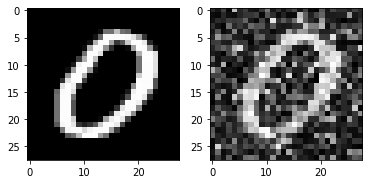

25  :  0.6096857558670908 25
50  :  0.614616568358268 25
75  :  0.37202557158335736 25
100  :  0.37202557158335736 25
125  :  0.6114201476801947 25
150  :  0.6124705655446782 25
175  :  0.6124705655446782 25
200  :  0.6124705655446782 25
225  :  0.6124705655446782 25
250  :  0.6124705655446782 25
275  :  0.6124705655446782 25
300  :  0.6124705655446782 25
325  :  0.6124705655446782 25
350  :  0.6124705655446782 25
375  :  0.6124705655446782 25
400  :  0.6124705655446782 25
425  :  0.6148654943353971 25
450  :  0.6172564342114221 25
475  :  0.6207634527481474 25
500  :  0.6212649417953205 25
525  :  0.6212649417953205 25
550  :  0.6247669889395189 25
575  :  0.6247669889395189 25
600  :  0.6263404630537289 25
625  :  0.6263427207373529 25
650  :  0.6263427207373529 25
675  :  0.6277401030127588 25
700  :  0.6283172675265813 25
725  :  0.6283019979515315 25
750  :  0.6300821337943033 25
775  :  0.6300821337943033 25
800  :  0.6306832071328823 25
825  :  0.6307646835513426 25
850  :  0.63

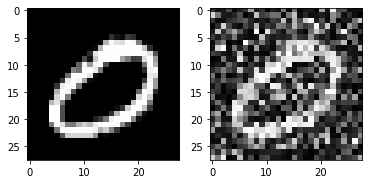

25  :  -0.35378849700966514 25
50  :  -0.35378849700966514 25
75  :  -0.3365471297223984 25
100  :  0.5771704571723182 25
125  :  0.5971608670567747 25
150  :  0.5855772509511178 25
175  :  0.5850457151021065 25
200  :  0.5917901968638875 25
225  :  0.5953554607747892 25
250  :  0.5953554607747892 25
275  :  0.5953554607747892 25
300  :  0.5953554607747892 25
325  :  0.5953554607747892 25
350  :  0.5953554607747892 25
375  :  0.5975977993093397 25
400  :  0.5980290737144451 25
425  :  0.5998894324858515 25
450  :  0.6011003124402007 25
475  :  0.6021425571341726 25
500  :  0.6016272294624624 25
525  :  0.6058337882331898 25
550  :  0.6058337882331898 25
575  :  0.6058337882331898 25
600  :  0.6058337882331898 25
625  :  0.6081876106071666 25
650  :  0.6094700496702424 25
675  :  0.6102277955096019 25
700  :  0.6103658633551969 25
725  :  0.6117145055999653 25
750  :  0.611521023190422 25
775  :  0.611521023190422 25
800  :  0.6118476751474067 25
825  :  0.6118476751474067 25
850  :  0.

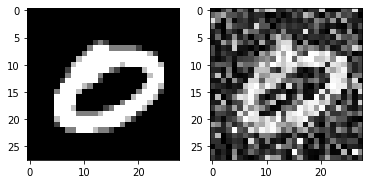

25  :  0.6159037868360183 25
50  :  0.6159037868360183 25
75  :  0.6159037868360183 25
100  :  0.6266318312527096 25
125  :  0.6309960924311339 25
150  :  0.6243857204672892 25
175  :  0.6243857204672892 25
200  :  0.6243857204672892 25
225  :  0.6243857204672892 25
250  :  0.6243857204672892 25
275  :  0.6243857204672892 25
300  :  0.6243857204672892 25
325  :  0.6243857204672892 25
350  :  0.6298223610495021 25
375  :  0.6309347343154076 25
400  :  0.6309347343154076 25
425  :  0.6309347343154076 25
450  :  0.6309347343154076 25
475  :  0.6309347343154076 25
500  :  0.6309347343154076 25
525  :  0.6309347343154076 25
550  :  0.6350464784394476 25
575  :  0.6397283672992898 25
600  :  0.639823288211937 25
625  :  0.639823288211937 25
650  :  0.639823288211937 25
675  :  0.6400082810866402 25
700  :  0.6399032378812227 25
725  :  0.6399032378812227 25
750  :  0.6406100131070727 25
775  :  0.6405892202326449 25
800  :  0.6421882114480078 25
825  :  0.6432931253404944 25
850  :  0.643341

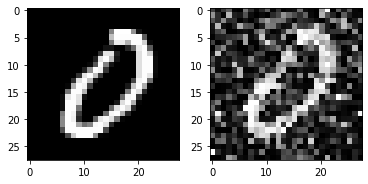

25  :  0.5339281812291936 25
50  :  0.5997353598271196 25
75  :  0.605181603333027 25
100  :  0.6267802140344876 25
125  :  0.6256136881554686 25
150  :  0.6256136881554686 25
175  :  0.6256136881554686 25
200  :  0.6256136881554686 25
225  :  0.6256136881554686 25
250  :  0.6256136881554686 25
275  :  0.6256136881554686 25
300  :  0.6302647026686973 25
325  :  0.6302647026686973 25
350  :  0.6326761974970242 25
375  :  0.6328480658864182 25
400  :  0.634616573768814 25
425  :  0.6387458295593255 25
450  :  0.6386725639521256 25
475  :  0.6386725639521256 25
500  :  0.6386725639521256 25
525  :  0.6399036816349248 25
550  :  0.6424811211787285 25
575  :  0.6424811211787285 25
600  :  0.6426171673673532 25
625  :  0.6434512064426627 25
650  :  0.6441505717383633 25
675  :  0.6441268045269698 25
700  :  0.6443322672940959 25
725  :  0.6446464678750858 25
750  :  0.6446457824216709 25
775  :  0.6453830891069805 25
800  :  0.6454273080850996 25
825  :  0.6455142531540676 25
850  :  0.64578

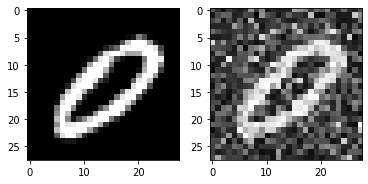

25  :  0.59711048645467 25
50  :  0.604317113155906 25
75  :  0.6146092844430933 25
100  :  0.6146092844430933 25
125  :  0.6146092844430933 25
150  :  0.6146092844430933 25
175  :  0.6146092844430933 25
200  :  0.6146092844430933 25
225  :  0.6192580015175899 25
250  :  0.6192580015175899 25
275  :  0.61943636820404 25
300  :  0.6199287632536893 25
325  :  0.6199287632536893 25
350  :  0.6199287632536893 25
375  :  0.6199287632536893 25
400  :  0.6235631970381366 25
425  :  0.6217535982808265 25
450  :  0.6217535982808265 25
475  :  0.6221503140270621 25
500  :  0.6256496844069649 25
525  :  0.6256496844069649 25
550  :  0.6257998157436414 25
575  :  0.6265884499928643 25
600  :  0.6285435651121828 25
625  :  0.6287648385686083 25
650  :  0.6304268956094836 25
675  :  0.6304268956094836 25
700  :  0.6304268956094836 25
725  :  0.6325791528519262 25
750  :  0.6328780324559626 25
775  :  0.6328447023868613 25
800  :  0.6332457961069615 25
825  :  0.6340629711655973 25
850  :  0.63406297

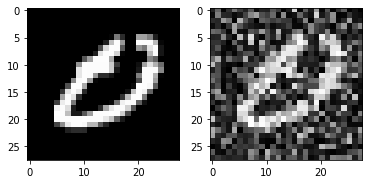

25  :  -0.08441003472083476 25
50  :  0.4345947680535682 25
75  :  0.5581074445962037 25
100  :  0.5623491735503519 25
125  :  0.5658661151079533 25
150  :  0.5703329802877124 25
175  :  0.5658661151079533 25
200  :  0.5682143663399079 25
225  :  0.5688997289083203 25
250  :  0.5689481784739537 25
275  :  0.5708463710222343 25
300  :  0.5711546685060789 25
325  :  0.5720177811570245 25
350  :  0.5735511970930169 25
375  :  0.5735853596019383 25
400  :  0.5735853596019383 25
425  :  0.5797181515261706 25
450  :  0.5802408311733778 25
475  :  0.5799868173589886 25
500  :  0.5799868173589886 25
525  :  0.5799868173589886 25
550  :  0.5799868173589886 25
575  :  0.5799868173589886 25
600  :  0.5812327431815555 25
625  :  0.5812215673587184 25
650  :  0.5815398345253269 25
675  :  0.58274396990064 25
700  :  0.5838385991271905 25
725  :  0.5846137128650196 25
750  :  0.5846802057326489 25
775  :  0.5852588958622997 25
800  :  0.5854622554147173 25
825  :  0.5855452017033886 25
850  :  0.586

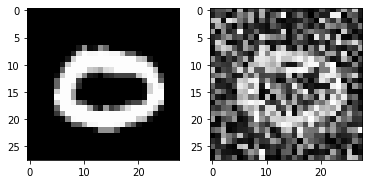

25  :  0.5771030253248528 25
50  :  0.5771030253248528 25
75  :  0.603929383992513 25
100  :  0.6096369726419668 25
125  :  0.6098024916937561 25
150  :  0.6137074133048421 25
175  :  0.614379000781115 25
200  :  0.614379000781115 25
225  :  0.614379000781115 25
250  :  0.614379000781115 25
275  :  0.6158557156439388 25
300  :  0.6143938494338157 25
325  :  0.6189424383573002 25
350  :  0.6199542070544614 25
375  :  0.6204969257462731 25
400  :  0.6204969257462731 25
425  :  0.6227859084543268 25
450  :  0.6229166445145261 25
475  :  0.6233729752770079 25
500  :  0.6233729752770079 25
525  :  0.6248884155494386 25
550  :  0.6248908455104978 25
575  :  0.6266849162547509 25
600  :  0.6266849162547509 25
625  :  0.6267300963372069 25
650  :  0.6279366132830297 25
675  :  0.627995461096401 25
700  :  0.6282033197250207 25
725  :  0.6285142191655797 25
750  :  0.629801911037968 25
775  :  0.6297304624296198 25
800  :  0.6297304624296198 25
825  :  0.6301783314480619 25
850  :  0.6302127493

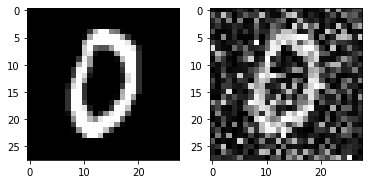

25  :  0.5705684412375023 25
50  :  0.6052412819846272 25
75  :  0.6065702812808418 25
100  :  0.6065702812808418 25
125  :  0.6065702812808418 25
150  :  0.6065702812808418 25
175  :  0.6065702812808418 25
200  :  0.6065702812808418 25
225  :  0.6065702812808418 25
250  :  0.6065702812808418 25
275  :  0.6065702812808418 25
300  :  0.6069529290249419 25
325  :  0.6084117749951324 25
350  :  0.6083224314317981 25
375  :  0.6083224314317981 25
400  :  0.6083224314317981 25
425  :  0.6083224314317981 25
450  :  0.6083224314317981 25
475  :  0.6090407067401582 25
500  :  0.6122455370730081 25
525  :  0.6119110617641299 25
550  :  0.6119110617641299 25
575  :  0.61487516589923 25
600  :  0.6148132850803694 25
625  :  0.6148132850803694 25
650  :  0.6148132850803694 25
675  :  0.6148132850803694 25
700  :  0.6152532293414346 25
725  :  0.6154582811415154 25
750  :  0.6154582811415154 25
775  :  0.6169968748300507 25
800  :  0.6169968748300507 25
825  :  0.6181238535949484 25
Time:  53.81370

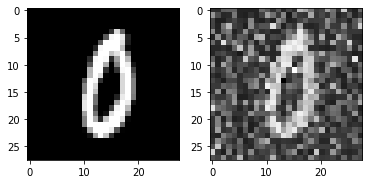

25  :  0.6022012254739143 25
50  :  0.6022012254739143 25
75  :  0.5956284650708402 25
100  :  0.5961959413891786 25
125  :  0.5981005672000395 25
150  :  0.5999960685820842 25
175  :  0.5999960685820842 25
200  :  0.5999960685820842 25
225  :  0.5999960685820842 25
250  :  0.5999960685820842 25
275  :  0.6025969587304375 25
300  :  0.6035769791942172 25
325  :  0.6035769791942172 25
350  :  0.6041398797217933 25
375  :  0.6042773975867702 25
400  :  0.6073508542038837 25
425  :  0.6072837597120877 25
450  :  0.6072837597120877 25
475  :  0.6072837597120877 25
500  :  0.6072837597120877 25
525  :  0.6072837597120877 25
550  :  0.6072837597120877 25
575  :  0.6072837597120877 25
600  :  0.6072837597120877 25
625  :  0.6072837597120877 25
650  :  0.6072837597120877 25
675  :  0.6095868451713503 25
700  :  0.6113050112023449 25
725  :  0.6113050112023449 25
750  :  0.6113050112023449 25
775  :  0.6113050112023449 25
800  :  0.6128548574411192 25
Time:  57.54777383804321  seconds
Predicted

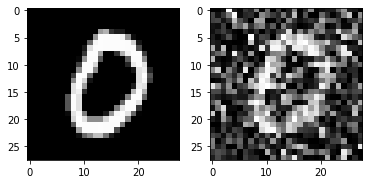

25  :  0.642753211011611 25
50  :  0.6527955066580229 25
75  :  0.6423130381983494 25
100  :  0.6456616690200452 25
125  :  0.6423130381983494 25
150  :  0.6423130381983494 25
175  :  0.6423130381983494 25
200  :  0.6423130381983494 25
225  :  0.6453316059038056 25
250  :  0.6488625560898251 25
275  :  0.6492694722171792 25
300  :  0.6488625560898251 25
325  :  0.6507953981635373 25
350  :  0.6506838668522068 25
375  :  0.651109476891139 25
400  :  0.6548007425489727 25
425  :  0.6560065597487579 25
450  :  0.656430410754298 25
475  :  0.656430410754298 25
500  :  0.6593268787769571 25
525  :  0.6592769472907435 25
550  :  0.6593521332861975 25
575  :  0.6593520758914098 25
600  :  0.6612383185275779 25
625  :  0.6628398254912763 25
650  :  0.6630511093465237 25
675  :  0.6630593386232166 25
700  :  0.6637248260018611 25
725  :  0.6646371537529505 25
750  :  0.666316659089752 25
775  :  0.6663076986940601 25
800  :  0.6668240376221397 25
825  :  0.6668240376221397 25
850  :  0.66682403

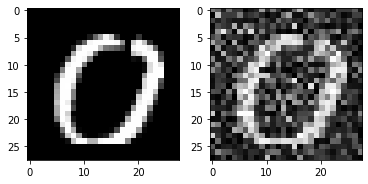

25  :  -0.24299233918196678 25
50  :  0.5766695170605631 25
75  :  0.5958493525272073 25
100  :  0.598317960474696 25
125  :  0.6067205315968076 25
150  :  0.6178540856578247 25
175  :  0.622817712432784 25
200  :  0.622817712432784 25
225  :  0.622817712432784 25
250  :  0.622817712432784 25
275  :  0.6249749867887473 25
300  :  0.6252017104343288 25
325  :  0.626901600972308 25
350  :  0.627618434900111 25
375  :  0.6288102078257458 25
400  :  0.6288102078257458 25
425  :  0.6288102078257458 25
450  :  0.6288102078257458 25
475  :  0.6288102078257458 25
500  :  0.6302607904527717 25
525  :  0.6306067442971218 25
550  :  0.6324843586402239 25
575  :  0.6324843586402239 25
600  :  0.6326370728726448 25
625  :  0.6348325110023351 25
650  :  0.6343518184429104 25
675  :  0.6343518184429104 25
700  :  0.6350962234672501 25
725  :  0.6360166237284758 25
750  :  0.6360202597390722 25
775  :  0.6367677646391584 25
800  :  0.6370592504224474 25
825  :  0.6386575271751652 25
850  :  0.63890467

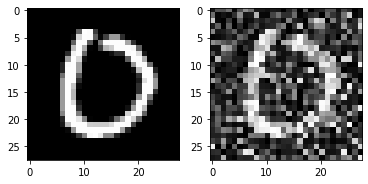

25  :  0.6461122413526109 25
50  :  0.650089737961888 25
75  :  0.6573217319363256 25
100  :  0.6581482706184391 25
125  :  0.658063341031986 25
150  :  0.658063341031986 25
175  :  0.6613749602351666 25
200  :  0.6613749602351666 25
225  :  0.6613749602351666 25
250  :  0.6613749602351666 25
275  :  0.6613749602351666 25
300  :  0.6613749602351666 25
325  :  0.6613749602351666 25
350  :  0.6615568996601321 25
375  :  0.6623085407491196 25
400  :  0.6645073342371985 25
425  :  0.6645787433042969 25
450  :  0.6645787433042969 25
475  :  0.6645787433042969 25
500  :  0.665918366449548 25
525  :  0.6682735186596398 25
550  :  0.6682193231358702 25
575  :  0.6696140776201164 25
600  :  0.6695351297247544 25
625  :  0.6695351297247544 25
650  :  0.6697308791775013 25
675  :  0.6715285041507635 25
700  :  0.6715285041507635 25
725  :  0.6718431398738852 25
750  :  0.6722337826733242 25
775  :  0.6728863796079191 25
800  :  0.672905429436177 25
Time:  48.39658856391907  seconds
Predicted clas

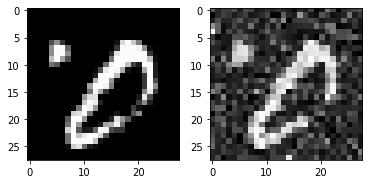

25  :  0.5780363021616737 25
50  :  0.5780363021616737 25
75  :  0.5780422805344083 25
100  :  0.5780422805344083 25
125  :  0.5819784785082489 25
150  :  0.5837797511884426 25
175  :  0.5837909954164726 25
200  :  0.5847930689249424 25
225  :  0.5847930689249424 25
250  :  0.5849372070549544 25
275  :  0.5846956772783916 25
300  :  0.5846956772783916 25
325  :  0.5846956772783916 25
350  :  0.5846956772783916 25
375  :  0.5858602114679607 25
400  :  0.5858453031866381 25
425  :  0.5858453031866381 25
450  :  0.5858453031866381 25
475  :  0.5858453031866381 25
500  :  0.5858453031866381 25
525  :  0.5858453031866381 25
550  :  0.5858453031866381 25
575  :  0.5861333405787728 25
600  :  0.5868332205592186 25
625  :  0.5868675527628093 25
650  :  0.5871346801299763 25
675  :  0.5871868691956955 25
700  :  0.5873464005623155 25
725  :  0.5873404204772446 25
750  :  0.5875587886802344 25
775  :  0.5876589201555553 25
800  :  0.5879187295690093 25
Time:  47.81169056892395  seconds
Predicted

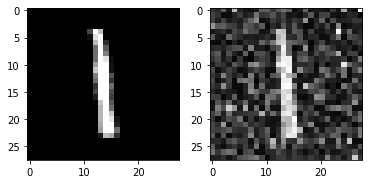

25  :  0.5851970244777294 25
50  :  0.5851970244777294 25
75  :  0.5851970244777294 25
100  :  0.5858707902694373 25
125  :  0.584700020360694 25
150  :  0.584700020360694 25
175  :  0.584700020360694 25
200  :  0.584700020360694 25
225  :  0.584700020360694 25
250  :  0.5847779875081942 25
275  :  0.584700020360694 25
300  :  0.584700020360694 25
325  :  0.5853875883658568 25
350  :  0.5880996557336869 25
375  :  0.5875234904722779 25
400  :  0.5875234904722779 25
425  :  0.5875234904722779 25
450  :  0.5875234904722779 25
475  :  0.5884877997146407 25
500  :  0.5882851125620212 25
525  :  0.5882851125620212 25
550  :  0.5890102708569296 25
575  :  0.5900338408412867 25
600  :  0.590043628721875 25
625  :  0.5913852869919691 25
650  :  0.5912696718269617 25
675  :  0.5917902309921548 25
700  :  0.5914554013068578 25
725  :  0.5922234591957521 25
750  :  0.5925933453253331 25
775  :  0.592671224621059 25
800  :  0.592755071349741 25
Time:  46.32808208465576  seconds
Predicted class:  [

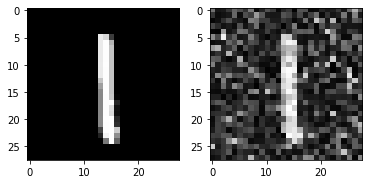

25  :  0.5686186357047589 25
50  :  0.5686186357047589 25
75  :  0.5686186357047589 25
100  :  0.5686186357047589 25
125  :  0.5686186357047589 25
150  :  0.569037670401993 25
175  :  0.5679326307019844 25
200  :  0.5679326307019844 25
225  :  0.5679326307019844 25
250  :  0.5679326307019844 25
275  :  0.5679326307019844 25
300  :  0.5679326307019844 25
325  :  0.5679326307019844 25
350  :  0.5679326307019844 25
375  :  0.5692257603902436 25
400  :  0.5697784481440389 25
425  :  0.5697784481440389 25
450  :  0.5697784481440389 25
475  :  0.5697784481440389 25
500  :  0.5697784481440389 25
525  :  0.5697784481440389 25
550  :  0.5704687798362834 25
575  :  0.5707223523308245 25
600  :  0.5712741038604953 25
625  :  0.5712529696018596 25
650  :  0.5715723224148062 25
675  :  0.5718970060684332 25
700  :  0.5722692795310188 25
725  :  0.5733545448620799 25
750  :  0.5738614339402 25
775  :  0.5738614339402 25
800  :  0.5738614339402 25
Time:  46.1709885597229  seconds
Predicted class:  [8

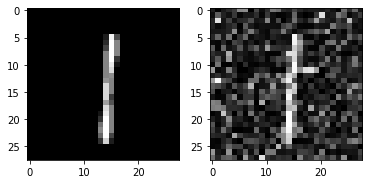

25  :  0.5781950290575248 25
50  :  0.5781950290575248 25
75  :  0.5787875286031093 25
100  :  0.5787875286031093 25
125  :  0.5787875286031093 25
150  :  0.5787875286031093 25
175  :  0.5787875286031093 25
200  :  0.5787875286031093 25
225  :  0.5787875286031093 25
250  :  0.5788319972112934 25
275  :  0.5788319972112934 25
300  :  0.5805317382029797 25
325  :  0.580227290659841 25
350  :  0.5806568456244107 25
375  :  0.5809570684413425 25
400  :  0.5809570684413425 25
425  :  0.5809570684413425 25
450  :  0.5809570684413425 25
475  :  0.5809570684413425 25
500  :  0.5809570684413425 25
525  :  0.5809570684413425 25
550  :  0.5818393314799948 25
575  :  0.5818393314799948 25
600  :  0.5818393314799948 25
625  :  0.5818393314799948 25
650  :  0.5826910168128165 25
675  :  0.5827579788320056 25
700  :  0.5827579788320056 25
725  :  0.5827579788320056 25
750  :  0.5830427303651909 25
775  :  0.5831522622679239 25
800  :  0.5831266889043808 25
Time:  46.29995155334473  seconds
Predicted 

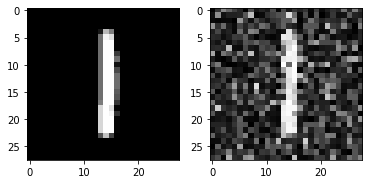

25  :  0.6038651825373673 25
50  :  0.6038651825373673 25
75  :  0.6038651825373673 25
100  :  0.6038651825373673 25
125  :  0.6038651825373673 25
150  :  0.6038651825373673 25
175  :  0.6038651825373673 25
200  :  0.6038651825373673 25
225  :  0.6038651825373673 25
250  :  0.6038651825373673 25
275  :  0.6038651825373673 25
300  :  0.6038651825373673 25
325  :  0.6038651825373673 25
350  :  0.6038651825373673 25
375  :  0.6051358694037151 25
400  :  0.6053233473339429 25
425  :  0.6052455100432838 25
450  :  0.6052892988125363 25
475  :  0.605416440703487 25
500  :  0.6053140100444308 25
525  :  0.6058245746377404 25
550  :  0.6054694211398454 25
575  :  0.6056896494386282 25
600  :  0.6060730810488733 25
625  :  0.6060801845606307 25
650  :  0.6060801845606307 25
675  :  0.6065938511332698 25
700  :  0.6066766755066425 25
725  :  0.6068061585213194 25
750  :  0.6071876713340518 25
775  :  0.6072606980142037 25
800  :  0.6073940790102026 25
Time:  47.065624713897705  seconds
Predicted

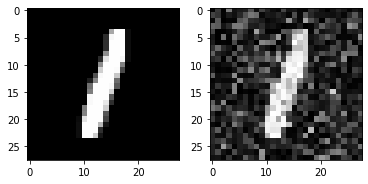

25  :  0.5875017391607918 25
50  :  0.5875017391607918 25
75  :  0.5875017391607918 25
100  :  0.5875017391607918 25
125  :  0.5875017391607918 25
150  :  0.5877800258087379 25
175  :  0.589151857864558 25
200  :  0.5911983180902102 25
225  :  0.5911983180902102 25
250  :  0.5911983180902102 25
275  :  0.5911983180902102 25
300  :  0.5911983180902102 25
325  :  0.5914749070372217 25
350  :  0.5914363223484258 25
375  :  0.5914363223484258 25
400  :  0.5914363223484258 25
425  :  0.5921521782512504 25
450  :  0.5928879281386057 25
475  :  0.592923513075857 25
500  :  0.5944605651344196 25
525  :  0.5945862671752773 25
550  :  0.5967050381116792 25
575  :  0.5967518229508261 25
600  :  0.5968013752028667 25
625  :  0.5968013752028667 25
650  :  0.5968013752028667 25
675  :  0.5968013752028667 25
700  :  0.5968013752028667 25
725  :  0.5968013752028667 25
750  :  0.5968013752028667 25
775  :  0.5968013752028667 25
800  :  0.5968013752028667 25
Time:  51.790042877197266  seconds
Predicted 

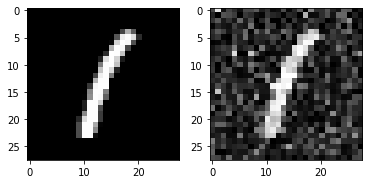

25  :  0.5774499885147681 25
50  :  0.5774499885147681 25
75  :  0.5774499885147681 25
100  :  0.5774499885147681 25
125  :  0.5774499885147681 25
150  :  0.5774499885147681 25
175  :  0.5774499885147681 25
200  :  0.5774499885147681 25
225  :  0.5774499885147681 25
250  :  0.5774499885147681 25
275  :  0.5774499885147681 25
300  :  0.5788339661260176 25
325  :  0.5787162363470244 25
350  :  0.5787162363470244 25
375  :  0.5787162363470244 25
400  :  0.5787162363470244 25
425  :  0.5787162363470244 25
450  :  0.5787162363470244 25
475  :  0.5787162363470244 25
500  :  0.5787162363470244 25
525  :  0.5787162363470244 25
550  :  0.5796043660122215 25
575  :  0.58214376988446 25
600  :  0.5819506847801938 25
625  :  0.5819506847801938 25
650  :  0.5821501425185514 25
675  :  0.582001913786891 25
700  :  0.582001913786891 25
725  :  0.5839531371895323 25
750  :  0.5839461113737736 25
775  :  0.5847155483698678 25
800  :  0.5847155483698678 25
Time:  48.45103430747986  seconds
Predicted cla

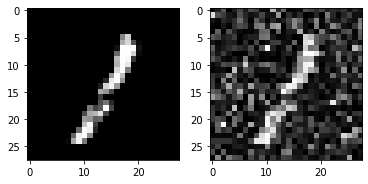

25  :  0.5799812533775224 25
50  :  0.5799812533775224 25
75  :  0.5799812533775224 25
100  :  0.5799812533775224 25
125  :  0.5799812533775224 25
150  :  0.5799812533775224 25
175  :  0.5819404827249561 25
200  :  0.5816566149003168 25
225  :  0.5839171566555961 25
250  :  0.5841727971100906 25
275  :  0.5841727971100906 25
300  :  0.5841727971100906 25
325  :  0.5841727971100906 25
350  :  0.5841727971100906 25
375  :  0.5857084033453048 25
400  :  0.5856476285145421 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


425  :  0.5856476285145421 25
450  :  0.5856476285145421 25
475  :  0.5856476285145421 25
500  :  0.5857018221552119 25
525  :  0.5857018221552119 25
550  :  0.5857018221552119 25
575  :  0.5860407707909099 25
600  :  0.5870517322281318 25
625  :  0.5870932041123047 25
650  :  0.5871111049203512 25
675  :  0.5873499008519734 25
700  :  0.5874213586185346 25
725  :  0.5875390706830803 25
750  :  0.5878267939754324 25
775  :  0.5880425268804031 25
800  :  0.5893252022416419 25
Time:  49.3047776222229  seconds
Predicted class:  [8]


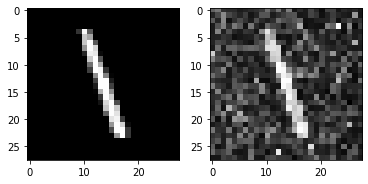

25  :  0.5915324772681134 25
50  :  0.5915324772681134 25
75  :  0.5915324772681134 25
100  :  0.5915324772681134 25
125  :  0.5915324772681134 25
150  :  0.5915324772681134 25
175  :  0.5915324772681134 25
200  :  0.5915324772681134 25
225  :  0.5915324772681134 25
250  :  0.5915324772681134 25
275  :  0.5915324772681134 25
300  :  0.5915324772681134 25
325  :  0.5915324772681134 25
350  :  0.5915324772681134 25
375  :  0.5915324772681134 25
400  :  0.5915324772681134 25
425  :  0.5915324772681134 25
450  :  0.5915324772681134 25
475  :  0.5915324772681134 25
500  :  0.5915324772681134 25
525  :  0.5915324772681134 25
550  :  0.5915324772681134 25
575  :  0.5915324772681134 25
600  :  0.5915324772681134 25
625  :  0.5915324772681134 25
650  :  0.5915324772681134 25
675  :  0.5923332310638693 25
700  :  0.5915327866735249 25
725  :  0.5915327866735249 25
750  :  0.5915327866735249 25
775  :  0.5915327866735249 25
800  :  0.5915419188072913 25
Time:  46.16551852226257  seconds
Predicted

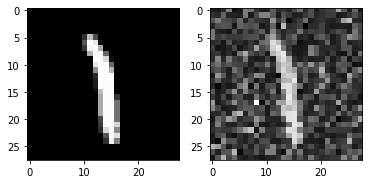

25  :  0.5745341860884022 25
50  :  0.576217001476656 25
75  :  0.5751849157407227 25
100  :  0.5751849157407227 25
125  :  0.5757877353120502 25
150  :  0.576669438519164 25
175  :  0.576669438519164 25
200  :  0.576669438519164 25
225  :  0.576669438519164 25
250  :  0.576669438519164 25
275  :  0.576669438519164 25
300  :  0.576669438519164 25
325  :  0.5800854923511876 25
350  :  0.5798735668530434 25
375  :  0.5798735668530434 25
400  :  0.5804744373822526 25
425  :  0.5801215625441525 25
450  :  0.5801215625441525 25
475  :  0.5801215625441525 25
500  :  0.5801215625441525 25
525  :  0.5806837375517266 25
550  :  0.580623886443301 25
575  :  0.5813590217157838 25
600  :  0.5812649191078622 25
625  :  0.5817689158357853 25
650  :  0.5816701070081354 25
675  :  0.5820628673497098 25
700  :  0.582040398098894 25
725  :  0.5820404353545432 25
750  :  0.5822101786385792 25
775  :  0.5821681375674498 25
800  :  0.5821748180820823 25
Time:  47.368781328201294  seconds
Predicted class:  

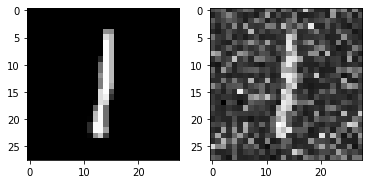

25  :  0.5898027656125586 25
50  :  0.5898027656125586 25
75  :  0.5901428598126757 25
100  :  0.5901428598126757 25
125  :  0.5901428598126757 25
150  :  0.5901428598126757 25
175  :  0.5901428598126757 25
200  :  0.5901428598126757 25
225  :  0.5905537669718527 25
250  :  0.5905505767489321 25
275  :  0.590910160127464 25
300  :  0.590910160127464 25
325  :  0.5924030772737837 25
350  :  0.5924152224006923 25
375  :  0.5931803861660995 25
400  :  0.5933005640904184 25
425  :  0.5945478063827522 25
450  :  0.5947477179261869 25
475  :  0.594757097415577 25
500  :  0.5961356543898094 25
525  :  0.5961356543898094 25
550  :  0.5961356543898094 25
575  :  0.596145663824573 25
600  :  0.596145663824573 25
625  :  0.596621005336518 25
650  :  0.5966919010550628 25
675  :  0.5967526484473838 25
700  :  0.597329863072978 25
725  :  0.5977612926952836 25
750  :  0.5979463555466017 25
775  :  0.5979531517565189 25
800  :  0.5982091644153127 25
Time:  48.226837158203125  seconds
Predicted class

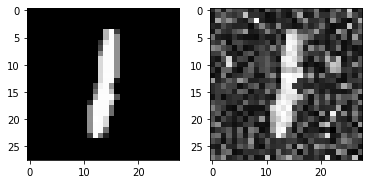

25  :  0.5764918967521055 25
50  :  0.5764918967521055 25
75  :  0.5764918967521055 25
100  :  0.5764918967521055 25
125  :  0.5764918967521055 25
150  :  0.5764918967521055 25
175  :  0.5764918967521055 25
200  :  0.5764918967521055 25
225  :  0.5764918967521055 25
250  :  0.5764918967521055 25
275  :  0.5764918967521055 25
300  :  0.5764918967521055 25
325  :  0.5764918967521055 25
350  :  0.5764918967521055 25
375  :  0.5764918967521055 25
400  :  0.5764918967521055 25
425  :  0.5764918967521055 25
450  :  0.5764918967521055 25
475  :  0.5774482456264304 25
500  :  0.5774726200794182 25
525  :  0.5786383215787599 25
550  :  0.5787480099905051 25
575  :  0.5787480099905051 25
600  :  0.580077545364865 25
625  :  0.5804622639347891 25
650  :  0.5806094281139663 25
675  :  0.5805345954301989 25
700  :  0.5805345954301989 25
725  :  0.5805345954301989 25
750  :  0.5806962722931797 25
775  :  0.5809453804560251 25
800  :  0.581401301634223 25
Time:  45.43468189239502  seconds
Predicted c

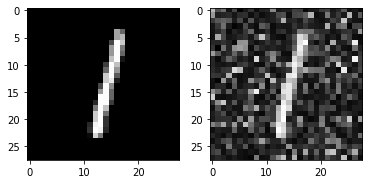

25  :  0.5940255731920498 25
50  :  0.5940255731920498 25
75  :  0.5940255731920498 25
100  :  0.5940255731920498 25
125  :  0.5940255731920498 25
150  :  0.5940255731920498 25
175  :  0.5940255731920498 25
200  :  0.5940255731920498 25
225  :  0.5940255731920498 25
250  :  0.5940255731920498 25
275  :  0.5940255731920498 25
300  :  0.5940255731920498 25
325  :  0.5940255731920498 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide


350  :  0.5940255731920498 25
375  :  0.5940255731920498 25
400  :  0.5940255731920498 25
425  :  0.5940255731920498 25
450  :  0.5940255731920498 25
475  :  0.5940255731920498 25
500  :  0.5940255731920498 25
525  :  0.5940255731920498 25
550  :  0.5940255731920498 25
575  :  0.5940255731920498 25
600  :  0.5940255731920498 25
625  :  0.5940255731920498 25
650  :  0.5940255731920498 25
675  :  0.5940255731920498 25
700  :  0.5940255731920498 25
725  :  0.5940255731920498 25
750  :  0.5940255731920498 25
775  :  0.5940255731920498 25
800  :  0.5940255731920498 25
Time:  48.5455436706543  seconds
Predicted class:  [8]


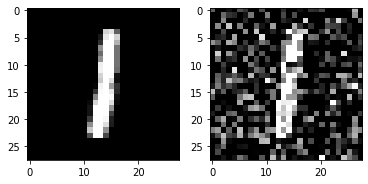

25  :  0.5811060121614329 25
50  :  0.5811060121614329 25
75  :  0.5816783498365669 25
100  :  0.5837153378438815 25
125  :  0.5840033089718509 25
150  :  0.5840033089718509 25
175  :  0.5840033089718509 25
200  :  0.5840653533325464 25
225  :  0.5846680477089624 25
250  :  0.5847007215771534 25
275  :  0.5886019727913059 25
300  :  0.5886019727913059 25
325  :  0.5910916825878499 25
350  :  0.5912186018903914 25
375  :  0.5912186018903914 25
400  :  0.5912186018903914 25
425  :  0.5912541185858518 25
450  :  0.5912471556932101 25
475  :  0.5916453059792677 25
500  :  0.5917007870262949 25
525  :  0.5925642627939726 25
550  :  0.5928587579032749 25
575  :  0.5928587579032749 25
600  :  0.5935684887367131 25
625  :  0.5936001168153517 25
650  :  0.5943827565939117 25
675  :  0.5945775470778141 25
700  :  0.5945300383670296 25
725  :  0.5951708806170652 25
750  :  0.5953137686216317 25
775  :  0.5953032421081194 25
800  :  0.5953607112370234 25
Time:  54.03105592727661  seconds
Predicted

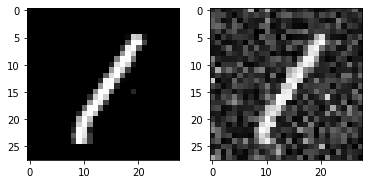

25  :  0.5879908033133432 25
50  :  0.5879908033133432 25
75  :  0.5889415496293962 25
100  :  0.5901959345796333 25
125  :  0.5901959345796333 25
150  :  0.5901959345796333 25
175  :  0.5901959345796333 25
200  :  0.5901959345796333 25
225  :  0.5918390331169141 25
250  :  0.5918390331169141 25
275  :  0.5918390331169141 25
300  :  0.5918390331169141 25
325  :  0.592325554533676 25
350  :  0.5922993438932936 25
375  :  0.5936530423099958 25
400  :  0.5936323540243563 25
425  :  0.5936323540243563 25
450  :  0.5936323540243563 25
475  :  0.5940520574320892 25
500  :  0.5940520574320892 25
525  :  0.5940520574320892 25
550  :  0.5940520574320892 25
575  :  0.5952040221742707 25
600  :  0.5952141081229132 25
625  :  0.5952141081229132 25
650  :  0.5952141081229132 25
675  :  0.5952141081229132 25
700  :  0.5957643805394146 25
725  :  0.5957038586454052 25
750  :  0.5957038586454052 25
775  :  0.5957038586454052 25
800  :  0.5957038586454052 25
Time:  51.917845487594604  seconds
Predicted

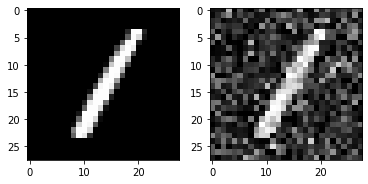

25  :  -0.3832585889995629 25
50  :  -0.3821048258476456 25
75  :  -0.37794444971028174 25
100  :  -0.37183340741021276 25
125  :  -0.3701412105893869 25
150  :  -0.3701412105893869 25
175  :  -0.3697327449580816 25
200  :  -0.36533477206516984 25
225  :  -0.3629096484319126 25
250  :  -0.36247092383868584 25
275  :  -0.3624615786477535 25
300  :  -0.3624615786477535 25
325  :  -0.3624615786477535 25
350  :  -0.3624615786477535 25
375  :  -0.3624615786477535 25
400  :  -0.361248889804082 25
425  :  -0.3603497382205854 25
450  :  -0.3603517334410624 25
475  :  -0.359877418188968 25
500  :  -0.35948640405482013 25
525  :  -0.35851040109842247 25
550  :  -0.3585104010984214 25
575  :  -0.3577059497723273 25
600  :  -0.3577059497723273 25
625  :  -0.357385679991846 25
650  :  -0.357387963380781 25
675  :  -0.35727913523949256 25
700  :  -0.35727913523949256 25
725  :  -0.35706068590952716 25
750  :  -0.35706068590952716 25
775  :  -0.35693888264355833 25
800  :  -0.35693888264355833 25
Tim

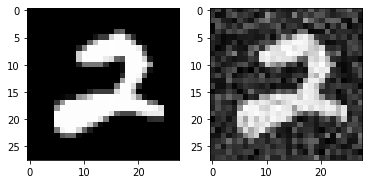

25  :  -0.3663265152594643 25
50  :  -0.06831762036688584 25
75  :  -0.052285196854205004 25
100  :  -0.052285196854205004 25
125  :  0.026041935083012863 25
150  :  0.5810831387543862 25
175  :  0.6085708580829599 25
200  :  0.5980774842856322 25
225  :  0.5994318713083174 25
250  :  0.5994318713083174 25
275  :  0.5994318713083174 25
300  :  0.602241086987671 25
325  :  0.6045494005636226 25
350  :  0.6045641740496759 25
375  :  0.6045641740496759 25
400  :  0.6045641740496759 25
425  :  0.6045641740496759 25
450  :  0.6045641740496759 25
475  :  0.6054481500042698 25
500  :  0.6052691810643638 25
525  :  0.6052691810643638 25
550  :  0.6052691810643638 25
575  :  0.6085314330042488 25
600  :  0.6110230462021311 25
625  :  0.611088437431171 25
650  :  0.611088437431171 25
675  :  0.611088437431171 25
700  :  0.611088437431171 25
725  :  0.611088437431171 25
750  :  0.6121165829018309 25
775  :  0.6121165829018309 25
800  :  0.6121165829018309 25
825  :  0.6146544963108057 25
850  :  

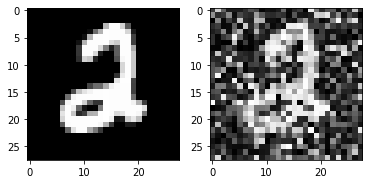

25  :  0.3018961606307677 25
50  :  0.46468674352786515 25
75  :  0.12222559728756406 25
100  :  0.5673725724439099 25
125  :  0.573234610720208 25
150  :  0.5789256120771126 25
175  :  0.5800307733995509 25
200  :  0.5800762601983357 25
225  :  0.5800762601983357 25
250  :  0.5800762601983357 25
275  :  0.5800762601983357 25
300  :  0.5800762601983357 25
325  :  0.5812523603836147 25
350  :  0.5800762601983357 25
375  :  0.5800762601983357 25
400  :  0.5800762601983357 25
425  :  0.5801099033772812 25
450  :  0.5837123280238338 25
475  :  0.5856511797915452 25
500  :  0.5874824243444214 25
525  :  0.590157400525936 25
550  :  0.5915155103108216 25
575  :  0.5915155103108216 25
600  :  0.5915155103108216 25
625  :  0.5915155103108216 25
650  :  0.5915155103108216 25
675  :  0.5928255353518497 25
700  :  0.5939481710604546 25
725  :  0.594058868378912 25
750  :  0.594053352216676 25
775  :  0.5946767687818164 25
800  :  0.5952716833668905 25
825  :  0.5957084558726611 25
850  :  0.59570

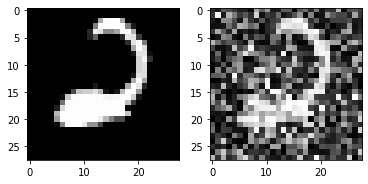

25  :  0.5829717362954561 25
50  :  0.5829717362954561 25
75  :  0.5928917623384855 25
100  :  0.5964135323102896 25
125  :  0.5964135323102896 25
150  :  0.5964135323102896 25
175  :  0.5964135323102896 25
200  :  0.597769146581182 25
225  :  0.597769146581182 25
250  :  0.597769146581182 25
275  :  0.597769146581182 25
300  :  0.597769146581182 25
325  :  0.602502853136921 25
350  :  0.6029574468697616 25
375  :  0.6037829808683727 25
400  :  0.6037829808683727 25
425  :  0.6037829808683727 25
450  :  0.6037829808683727 25
475  :  0.6037829808683727 25
500  :  0.6040002437751602 25
525  :  0.6042241443925781 25
550  :  0.6067656557164768 25
575  :  0.6067656557164768 25
600  :  0.6067656557164768 25
625  :  0.6067656557164768 25
650  :  0.6067656557164768 25
675  :  0.6067656557164768 25
700  :  0.6067656557164768 25
725  :  0.6075239896478399 25
750  :  0.6091061050029803 25
775  :  0.6091038908858051 25
800  :  0.6100826171725714 25
Time:  46.53667402267456  seconds
Predicted class

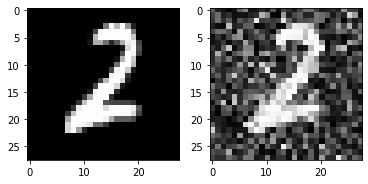

25  :  0.5732713621378118 25
50  :  0.5732713621378118 25
75  :  0.5835079595187157 25
100  :  0.5884381715750915 25
125  :  0.587162882129222 25
150  :  0.5880549147602622 25
175  :  0.5927900954109784 25
200  :  0.5924815877914097 25
225  :  0.5924815877914097 25
250  :  0.5924815877914097 25
275  :  0.5951663353125848 25
300  :  0.5946567766372841 25
325  :  0.5946567766372841 25
350  :  0.596368349022156 25
375  :  0.5972448391347454 25
400  :  0.597169310777985 25
425  :  0.597169310777985 25
450  :  0.5975321822785389 25
475  :  0.6009924516322979 25
500  :  0.6003268731008222 25
525  :  0.6021446006419929 25
550  :  0.6024105113796394 25
575  :  0.6024105113796394 25
600  :  0.6024105113796394 25
625  :  0.6032729048684949 25
650  :  0.603597106885569 25
675  :  0.6077282055991349 25
700  :  0.6076972286488435 25
725  :  0.6076972286488435 25
750  :  0.6076972286488435 25
775  :  0.6094254132531599 25
800  :  0.6096001697412256 25
825  :  0.6097892899609004 25
850  :  0.61041390

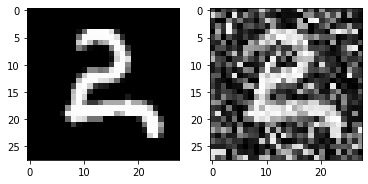

25  :  0.585038484736416 25
50  :  0.58637021021997 25
75  :  0.5861028666726451 25
100  :  0.5893653518229396 25
125  :  0.5921872714852294 25
150  :  0.5982080673665353 25
175  :  0.5937022964601241 25
200  :  0.5937022964601241 25
225  :  0.5947884863735768 25
250  :  0.5994605957226657 25
275  :  0.5994605957226657 25
300  :  0.6019815833669853 25
325  :  0.6021590553258469 25
350  :  0.6041900122123525 25
375  :  0.6041900122123525 25
400  :  0.6041900122123525 25
425  :  0.6047406806172935 25
450  :  0.6047295961461254 25
475  :  0.6050389334038341 25
500  :  0.605611699784128 25
525  :  0.6061121482718983 25
550  :  0.6070133458444422 25
575  :  0.6070082394959715 25
600  :  0.6080933880705368 25
625  :  0.6080877497064042 25
650  :  0.6091441247327989 25
675  :  0.6091440720017716 25
700  :  0.6093790105234405 25
725  :  0.6093680473252938 25
750  :  0.6106463816453043 25
775  :  0.6109789844673663 25
800  :  0.6109299498245876 25
Time:  44.73356342315674  seconds
Predicted cla

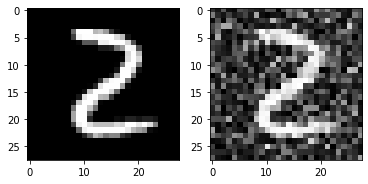

25  :  0.5610873191016573 25
50  :  0.6076487575653103 25
75  :  0.6089987913695263 25
100  :  0.6094669968932236 25
125  :  0.6117352052310787 25
150  :  0.6117352052310787 25
175  :  0.6143420814830085 25
200  :  0.6203115623181087 25
225  :  0.6203115623181087 25
250  :  0.6203115623181087 25
275  :  0.6203115623181087 25
300  :  0.6203115623181087 25
325  :  0.6203115623181087 25
350  :  0.6230548352388774 25
375  :  0.625381366729231 25
400  :  0.6300421218645715 25
425  :  0.6300421218645715 25
450  :  0.6300421218645715 25
475  :  0.6301590300873264 25
500  :  0.6301694282086561 25
525  :  0.6330868194060264 25
550  :  0.6337196943950869 25
575  :  0.6343630040097687 25
600  :  0.6343736046068692 25
625  :  0.6347476892756501 25
650  :  0.6347804551834372 25
675  :  0.6350113746608892 25
700  :  0.6358881138368726 25
725  :  0.6359016876693799 25
750  :  0.637301847013515 25
775  :  0.6372890056398202 25
800  :  0.6372890056398202 25
825  :  0.6372890056398202 25
Time:  46.18514

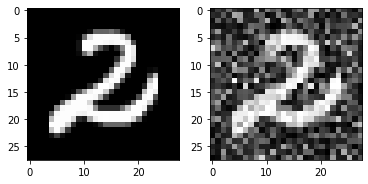

25  :  0.5702605981748912 25
50  :  0.5872889140987486 25
75  :  0.5945479080299655 25
100  :  0.5945479080299655 25
125  :  0.5945479080299655 25
150  :  0.5945479080299655 25
175  :  0.5945479080299655 25
200  :  0.5945479080299655 25
225  :  0.5945479080299655 25
250  :  0.5945479080299655 25
275  :  0.5945479080299655 25
300  :  0.5945479080299655 25
325  :  0.5945479080299655 25
350  :  0.5947415483702572 25
375  :  0.5950377343184385 25
400  :  0.5950377343184385 25
425  :  0.5960463038041679 25
450  :  0.5983450114414778 25
475  :  0.5983450114414778 25
500  :  0.5983450114414778 25
525  :  0.5983450114414778 25
550  :  0.5983450114414778 25
575  :  0.5998867545765085 25
600  :  0.5997881385764858 25
625  :  0.6022865926164874 25
650  :  0.6022015754625251 25
675  :  0.6023844155678715 25
700  :  0.6048711718474359 25
725  :  0.6048926127506371 25
750  :  0.6048926127506371 25
775  :  0.6048926127506371 25
800  :  0.6050070975273882 25
825  :  0.6055559533849577 25
Time:  46.298

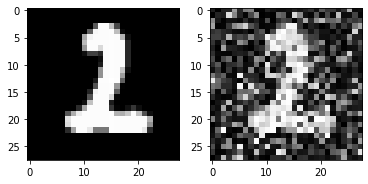

25  :  -0.33816274451211376 25
50  :  -0.14801001036192257 25
75  :  0.08697880742264834 25
100  :  0.5832656950889681 25
125  :  0.5889288081022376 25
150  :  0.5889288081022376 25
175  :  0.5889288081022376 25
200  :  0.5889288081022376 25
225  :  0.5944884068757086 25
250  :  0.5938217642601795 25
275  :  0.5938217642601795 25
300  :  0.5938217642601795 25
325  :  0.5938217642601795 25
350  :  0.5938217642601795 25
375  :  0.5938217642601795 25
400  :  0.5938217642601795 25
425  :  0.5943179891057535 25
450  :  0.5942174942949259 25
475  :  0.5981250934971442 25
500  :  0.5981400650047473 25
525  :  0.5989782540622333 25
550  :  0.5991106928333482 25
575  :  0.5991106928333482 25
600  :  0.6011730826193059 25
625  :  0.6012300239252862 25
650  :  0.6015696980465565 25
675  :  0.6028919288720171 25
700  :  0.6030989045715006 25
725  :  0.6054476745750482 25
750  :  0.6052851556811842 25
775  :  0.6052851556811842 25
800  :  0.6059877773058711 25
825  :  0.606425124729964 25
850  :  0

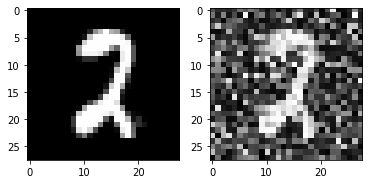

25  :  -0.2598398503328773 25
50  :  0.32444709439172476 25
75  :  0.570432180375376 25
100  :  0.5746443564920295 25
125  :  0.5851640878272981 25
150  :  0.5883453504947402 25
175  :  0.5883453504947402 25
200  :  0.5883453504947402 25
225  :  0.5883453504947402 25
250  :  0.5883453504947402 25
275  :  0.5883453504947402 25
300  :  0.5883453504947402 25
325  :  0.5923139287683176 25
350  :  0.5923139287683176 25
375  :  0.5927586812513188 25
400  :  0.5927792363277731 25
425  :  0.5939461393791138 25
450  :  0.5949542626684092 25
475  :  0.5960327045548847 25
500  :  0.5973382668552286 25
525  :  0.5973382668552286 25
550  :  0.5987765403093978 25
575  :  0.5988048651063931 25
600  :  0.6006318672168677 25
625  :  0.6005732947564532 25
650  :  0.6010545149991912 25
675  :  0.6018641844361262 25
700  :  0.6021936288522746 25
725  :  0.6021839133823387 25
750  :  0.6022283459057287 25
775  :  0.6022283459057287 25
800  :  0.6025947260861917 25
825  :  0.6026317054582806 25
850  :  0.60

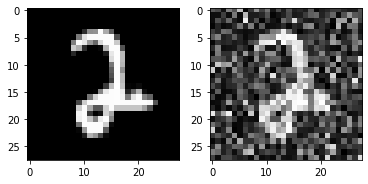

25  :  0.4388246074741621 25
50  :  0.5911200699882944 25
75  :  0.5961613504233954 25
100  :  0.5961409612473288 25
125  :  0.5961409612473288 25
150  :  0.5977963844330986 25
175  :  0.5975667876742892 25
200  :  0.5975667876742892 25
225  :  0.5987943686275959 25
250  :  0.5975667876742892 25
275  :  0.5981670181889451 25
300  :  0.6000505027043057 25
325  :  0.6013549072537805 25
350  :  0.6025849881439349 25
375  :  0.6030572873970591 25
400  :  0.6030572873970591 25
425  :  0.6033808444387571 25
450  :  0.6041630753390537 25
475  :  0.6043553224196954 25
500  :  0.6093322768361251 25
525  :  0.6097775675211284 25
550  :  0.6113698672878227 25
575  :  0.6113673384041657 25
600  :  0.6113673384041657 25
625  :  0.612782159521964 25
650  :  0.612782159521964 25
675  :  0.612782159521964 25
700  :  0.612782159521964 25
725  :  0.6133673854234167 25
750  :  0.6143751685312854 25
775  :  0.6146270391371521 25
800  :  0.6146998042921908 25
825  :  0.6146998042921908 25
Time:  51.4899654

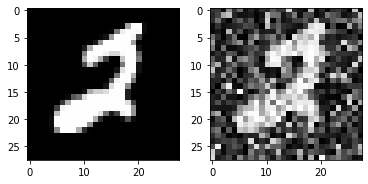

25  :  -0.2128296650055747 25
50  :  0.5687258929922087 25
75  :  0.5595442886744831 25
100  :  0.5639382896918357 25
125  :  0.5638864958669724 25
150  :  0.5691909631779248 25
175  :  0.5699864560352829 25
200  :  0.5699864560352829 25
225  :  0.5713842990384519 25
250  :  0.5732320465405714 25
275  :  0.5731421033733627 25
300  :  0.5743603220785263 25
325  :  0.5742423101929854 25
350  :  0.5747203225713265 25
375  :  0.5756611499777607 25
400  :  0.5773807543944764 25
425  :  0.5773814982351353 25
450  :  0.5793804671271189 25
475  :  0.5797295132276825 25
500  :  0.5804635210576065 25
525  :  0.5815163318700199 25
550  :  0.581843215561315 25
575  :  0.5820971981760076 25
600  :  0.5822944076826159 25
625  :  0.5822927756030865 25
650  :  0.5841204385142547 25
675  :  0.5841218392234069 25
700  :  0.5842256649949441 25
725  :  0.5842619937101396 25
750  :  0.584383346463067 25
775  :  0.584880870235843 25
800  :  0.5851263968450464 25
825  :  0.5851953919035612 25
Time:  50.73675

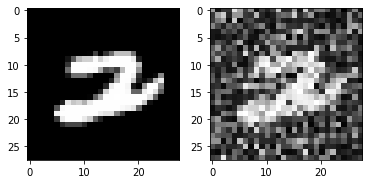

25  :  0.6114395324585931 25
50  :  0.6114395324585931 25
75  :  0.6114395324585931 25
100  :  0.6114395324585931 25
125  :  0.6114395324585931 25
150  :  0.6114395324585931 25
175  :  0.6128428836855097 25
200  :  0.6128428836855097 25
225  :  0.6128428836855097 25
250  :  0.6160907653959395 25
275  :  0.6160907653959395 25
300  :  0.6160907653959395 25
325  :  0.6164368709728952 25
350  :  0.6164368709728952 25
375  :  0.6164477785012122 25
400  :  0.6171799502939254 25
425  :  0.6171799502939254 25
450  :  0.6171799502939254 25
475  :  0.6172899357244199 25
500  :  0.6172067467609625 25
525  :  0.6172067467609625 25
550  :  0.6173481824610818 25
575  :  0.6173571126288064 25
600  :  0.6189707937642576 25
625  :  0.619466238148112 25
650  :  0.6194656993739324 25
675  :  0.6199140803203089 25
700  :  0.6202775813549336 25
725  :  0.6202687153743878 25
750  :  0.6203326865255946 25
775  :  0.6204080527251796 25
800  :  0.6208266598847764 25
Time:  47.77992534637451  seconds
Predicted 

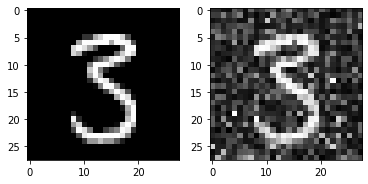

25  :  0.6075292887034097 25
50  :  0.6075292887034097 25
75  :  0.6075292887034097 25
100  :  0.6075292887034097 25
125  :  0.609510891474017 25
150  :  0.6095553201553952 25
175  :  0.6095553201553952 25
200  :  0.6130775277046995 25
225  :  0.6130775277046995 25
250  :  0.6138335298865416 25
275  :  0.6187467893552652 25
300  :  0.6187467893552652 25
325  :  0.6187467893552652 25
350  :  0.6227323974705468 25
375  :  0.6285162633257146 25
400  :  0.6285142086569573 25
425  :  0.6285142086569573 25
450  :  0.6285142086569573 25
475  :  0.6285142086569573 25
500  :  0.6285142086569573 25
525  :  0.6285142086569573 25
550  :  0.6292243484892788 25
575  :  0.6308382923427283 25
600  :  0.6311864367827713 25
625  :  0.6317970334315849 25
650  :  0.6317970334315849 25
675  :  0.6321799377581562 25
700  :  0.6322232453865051 25
725  :  0.6322232453865051 25
750  :  0.6322232453865051 25
775  :  0.6322384755944804 25
800  :  0.6322384755944804 25
Time:  47.51417779922485  seconds
Predicted 

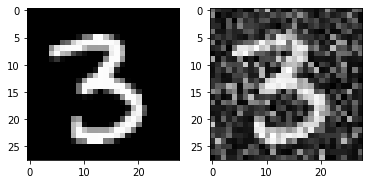

25  :  0.5977367657249067 25
50  :  0.6119485610882232 25
75  :  0.6176036593148386 25
100  :  0.6176036593148386 25
125  :  0.6176036593148386 25
150  :  0.6201508581822575 25
175  :  0.6231546954173706 25
200  :  0.6292414435287662 25
225  :  0.6319831443572934 25
250  :  0.6319831443572934 25
275  :  0.6319831443572934 25
300  :  0.6319831443572934 25
325  :  0.6319831443572934 25
350  :  0.6323795161629191 25
375  :  0.6323959210793293 25
400  :  0.6323959210793293 25
425  :  0.6323959210793293 25
450  :  0.6344400685229621 25
475  :  0.6345386069337495 25
500  :  0.6345386069337495 25
525  :  0.6345386069337495 25
550  :  0.6349669769907142 25
575  :  0.63521709014889 25
600  :  0.6353053829770957 25
625  :  0.6367744553086246 25
650  :  0.6377218013881578 25
675  :  0.6375608594626455 25
700  :  0.6377902692876165 25
725  :  0.6384412897336118 25
750  :  0.6390476700307905 25
775  :  0.6398707233871036 25
800  :  0.6401678197399481 25
825  :  0.640736505952367 25
Time:  50.446208

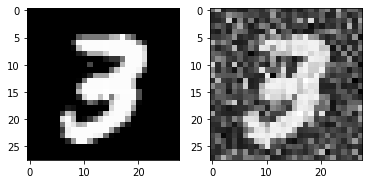

25  :  0.607989859960299 25
50  :  0.607989859960299 25
75  :  0.6129719044611264 25
100  :  0.6129719044611264 25
125  :  0.6129719044611264 25
150  :  0.613548495405586 25
175  :  0.613548495405586 25
200  :  0.6145766552459673 25
225  :  0.6189066860556499 25
250  :  0.6189053542740316 25
275  :  0.6194313851569008 25
300  :  0.6194313851569008 25
325  :  0.6194313851569008 25
350  :  0.6194313851569008 25
375  :  0.6200347816249935 25
400  :  0.6201306254533413 25
425  :  0.6203490359558468 25
450  :  0.6212634276723705 25
475  :  0.6225814936678589 25
500  :  0.6234504494285343 25
525  :  0.6234277796235476 25
550  :  0.6234277796235476 25
575  :  0.6234277796235476 25
600  :  0.623572421929942 25
625  :  0.6236821356420712 25
650  :  0.6245044561800903 25
675  :  0.6246263544013124 25
700  :  0.6250170957921451 25
725  :  0.6253890872977642 25
750  :  0.6254527793231655 25
775  :  0.6258309978682267 25
800  :  0.6259157243849485 25
Time:  51.62788438796997  seconds
Predicted clas

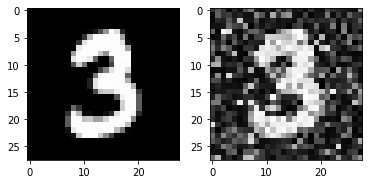

25  :  0.5979004839057084 25
50  :  0.5979004839057084 25
75  :  0.6043831420235081 25
100  :  0.6061997185313662 25
125  :  0.6061997185313662 25
150  :  0.6073947833462248 25
175  :  0.6089002336950015 25
200  :  0.6089002336950015 25
225  :  0.6089002336950015 25
250  :  0.6089002336950015 25
275  :  0.6089002336950015 25
300  :  0.6185441783160722 25
325  :  0.6189225256332708 25
350  :  0.6189225256332708 25
375  :  0.6199481255775189 25
400  :  0.6216785965104414 25
425  :  0.6216785965104414 25
450  :  0.6216785965104414 25
475  :  0.623656495052304 25
500  :  0.6237715067684202 25
525  :  0.6237715067684202 25
550  :  0.6240800557967013 25
575  :  0.6247693899583711 25
600  :  0.6247693899583711 25
625  :  0.625331943337408 25
650  :  0.626661121542622 25
675  :  0.626661121542622 25
700  :  0.626661121542622 25
725  :  0.6286176313555366 25
750  :  0.6296772805220674 25
775  :  0.6297721381552323 25
800  :  0.6304095543115829 25
Time:  47.8065972328186  seconds
Predicted class

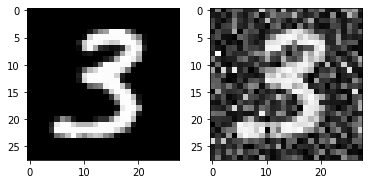

25  :  0.5170087915287239 25
50  :  0.5800993246922148 25
75  :  0.5810357756660969 25
100  :  0.5872225544721001 25
125  :  0.5822853343485673 25
150  :  0.5837438654503826 25
175  :  0.5856597744991484 25
200  :  0.5873860237948351 25
225  :  0.5889404676386568 25
250  :  0.5894586351343202 25
275  :  0.5896659350294139 25
300  :  0.5915583882602495 25
325  :  0.5929685686835651 25
350  :  0.5928624478575353 25
375  :  0.5948900295460219 25
400  :  0.5948900295460219 25
425  :  0.5970557019040222 25
450  :  0.5970557019040222 25
475  :  0.5971663370828599 25
500  :  0.5975242689017313 25
525  :  0.5977482669822057 25
550  :  0.5977585382144952 25
575  :  0.5982496395311074 25
600  :  0.5999949054196596 25
625  :  0.600443307070419 25
650  :  0.6007987662692852 25
675  :  0.6008021935363598 25
700  :  0.6008826458260872 25
725  :  0.6012993075240581 25
750  :  0.602003986216198 25
775  :  0.6021765741982664 25
800  :  0.6021765741982664 25
825  :  0.6022986361773145 25
Time:  50.05182

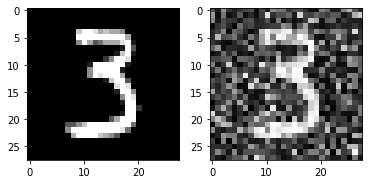

25  :  0.48144391414644333 25
50  :  0.5802613926005016 25
75  :  0.5904212099038858 25
100  :  0.5904212099038858 25
125  :  0.5911635168844885 25
150  :  0.5917447522385226 25
175  :  0.5917447522385226 25
200  :  0.5917447522385226 25
225  :  0.5917447522385226 25
250  :  0.5963688069089996 25
275  :  0.5965206301594079 25
300  :  0.6003621952839002 25
325  :  0.6009920336959476 25
350  :  0.6009920336959476 25
375  :  0.605353721462686 25
400  :  0.605353721462686 25
425  :  0.605353721462686 25
450  :  0.605353721462686 25
475  :  0.605353721462686 25
500  :  0.6061717014260091 25
525  :  0.6084952934175005 25
550  :  0.6084444730576246 25
575  :  0.6084444730576246 25
600  :  0.6084444730576246 25
625  :  0.6094972670078227 25
650  :  0.609948915688592 25
675  :  0.6110670383929172 25
700  :  0.6111288817427482 25
725  :  0.6114407650503985 25
750  :  0.6131536473732735 25
775  :  0.6131607912155799 25
800  :  0.6131607912155799 25
825  :  0.613818762536638 25
850  :  0.614161269

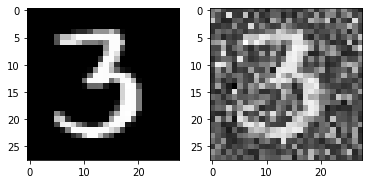

25  :  0.07491193407776876 25
50  :  0.5528906427442546 25
75  :  0.5871588998346807 25
100  :  0.5867856191418717 25
125  :  0.5867856191418717 25
150  :  0.5867856191418717 25
175  :  0.5867856191418717 25
200  :  0.5875034873802291 25
225  :  0.5907916025895463 25
250  :  0.5910943785234468 25
275  :  0.5910943785234468 25
300  :  0.5920173053828163 25
325  :  0.5934875808351655 25
350  :  0.5934875808351655 25
375  :  0.5935882735752036 25
400  :  0.597378733694661 25
425  :  0.5990587127051512 25
450  :  0.5990587127051512 25
475  :  0.5990587127051512 25
500  :  0.5992310743897279 25
525  :  0.599204617119973 25
550  :  0.6009899308458562 25
575  :  0.6013713598512714 25
600  :  0.6015135105383257 25
625  :  0.6024423638097458 25
650  :  0.6024332468621556 25
675  :  0.6033758120210536 25
700  :  0.6034149070213499 25
725  :  0.6034149070213499 25
750  :  0.6045856387426671 25
775  :  0.6045856387426671 25
800  :  0.6050054494412782 25
825  :  0.6052722391615201 25
850  :  0.6052

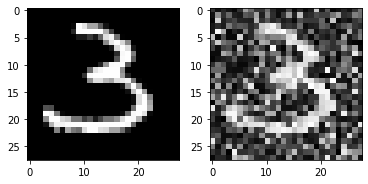

25  :  0.5948087045710135 25
50  :  0.5948087045710135 25
75  :  0.5948087045710135 25
100  :  0.5948087045710135 25
125  :  0.5948087045710135 25
150  :  0.5948087045710135 25
175  :  0.5951687231694905 25
200  :  0.6016922768332738 25
225  :  0.6016922768332738 25
250  :  0.6016922768332738 25
275  :  0.6016922768332738 25
300  :  0.6016922768332738 25
325  :  0.6016922768332738 25
350  :  0.6037323620523455 25
375  :  0.6037323620523455 25
400  :  0.6041523774491995 25
425  :  0.6041773437521682 25
450  :  0.6041773437521682 25
475  :  0.6041773437521682 25
500  :  0.6065939699538325 25
525  :  0.6063751507613997 25
550  :  0.6088005595502992 25
575  :  0.6091242768861597 25
600  :  0.6091242768861597 25
625  :  0.6103575709401045 25
650  :  0.610644838467945 25
675  :  0.6126891781551486 25
700  :  0.6126666823175735 25
725  :  0.613774291613833 25
750  :  0.6137898709395205 25
775  :  0.6141816607396244 25
800  :  0.6141783645154563 25
Time:  44.73471665382385  seconds
Predicted c

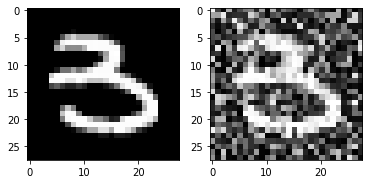

25  :  0.5776703118286891 25
50  :  0.5776703118286891 25
75  :  0.5788127447753121 25
100  :  0.5817984067196904 25
125  :  0.5817984067196904 25
150  :  0.5817984067196904 25
175  :  0.5823203910352692 25
200  :  0.5845497321185547 25
225  :  0.5846223506772807 25
250  :  0.586207809968726 25
275  :  0.5860365568539231 25
300  :  0.5863560600697535 25
325  :  0.5886905226812115 25
350  :  0.589233441038068 25
375  :  0.5894633038383018 25
400  :  0.5894633038383018 25
425  :  0.5894633038383018 25
450  :  0.5900115105124313 25
475  :  0.5905862991523192 25
500  :  0.5913802142033946 25
525  :  0.5912379522236327 25
550  :  0.591653538738113 25
575  :  0.5921869075031323 25
600  :  0.5921869075031323 25
625  :  0.5925668738264995 25
650  :  0.5929854738366188 25
675  :  0.5935732294531798 25
700  :  0.5943734584787158 25
725  :  0.5943734584787158 25
750  :  0.594594699954923 25
775  :  0.5949205982025144 25
800  :  0.5954585555137698 25
Time:  45.37555003166199  seconds
Predicted cla

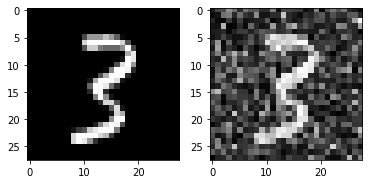

25  :  0.587549010483286 25
50  :  0.587549010483286 25
75  :  0.5910352026790758 25
100  :  0.6022652043759563 25
125  :  0.6022652043759563 25
150  :  0.6022652043759563 25
175  :  0.6022652043759563 25
200  :  0.6022652043759563 25
225  :  0.6038288710764492 25
250  :  0.604007856325234 25
275  :  0.6062219030260417 25
300  :  0.6062219030260417 25
325  :  0.6062219030260417 25
350  :  0.6071542018398096 25
375  :  0.6080835071179647 25
400  :  0.6080835071179647 25
425  :  0.6094161790013589 25
450  :  0.6094472747349016 25
475  :  0.6110272434625195 25
500  :  0.611627411697126 25
525  :  0.6122477722077608 25
550  :  0.6131432379312666 25
575  :  0.6131532326993429 25
600  :  0.6131532326993429 25
625  :  0.6131532326993429 25
650  :  0.6138602017359348 25
675  :  0.614091917192434 25
700  :  0.6141822171184546 25
725  :  0.6144081785029074 25
750  :  0.6144199812034251 25
775  :  0.6147102808542599 25
800  :  0.6147808151147441 25
825  :  0.6148587355290814 25
850  :  0.61505953

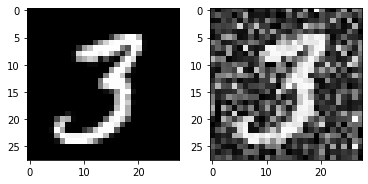

25  :  0.4929637879627188 25
50  :  0.4929637879627188 25
75  :  0.4792942548892801 25
100  :  0.6017530882438588 25
125  :  0.6038348221763306 25
150  :  0.6051362346932075 25
175  :  0.604163138535187 25
200  :  0.604163138535187 25
225  :  0.6046768717596576 25
250  :  0.6061059638704717 25
275  :  0.6068878499666006 25
300  :  0.6073864816393487 25
325  :  0.6073864816393487 25
350  :  0.6074440880942118 25
375  :  0.6118324972968338 25
400  :  0.6114388894708895 25
425  :  0.6139640923352903 25
450  :  0.6139640923352903 25
475  :  0.6139640923352903 25
500  :  0.6139640923352903 25
525  :  0.6139640923352903 25
550  :  0.6146591733071776 25
575  :  0.6168600108348054 25
600  :  0.6171142923013914 25
625  :  0.6174956525674633 25
650  :  0.6178513698727233 25
675  :  0.6180592994401672 25
700  :  0.6180609723888189 25
725  :  0.6185709551476589 25
750  :  0.6190984103564829 25
775  :  0.6194920871921934 25
800  :  0.6194919128793448 25
825  :  0.62002183042016 25
850  :  0.6201523

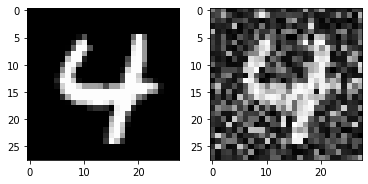

25  :  0.41041662081057917 25
50  :  0.6153550665460572 25
75  :  0.6213211324455244 25
100  :  0.6276118341483311 25
125  :  0.6276118341483311 25
150  :  0.6276118341483311 25
175  :  0.6276118341483311 25
200  :  0.6276118341483311 25
225  :  0.6276118341483311 25
250  :  0.6276118341483311 25
275  :  0.6276118341483311 25
300  :  0.6283928064407507 25
325  :  0.6284093858619864 25
350  :  0.6284093858619864 25
375  :  0.6286948126368433 25
400  :  0.6309397709315226 25
425  :  0.6309397709315226 25
450  :  0.6312829154928691 25
475  :  0.6314379783458952 25
500  :  0.6341659864435981 25
525  :  0.6345181472804887 25
550  :  0.6348631345445899 25
575  :  0.6350837987493569 25
600  :  0.64002465416344 25
625  :  0.64002465416344 25
650  :  0.64002465416344 25
675  :  0.64002465416344 25
700  :  0.6403172471031809 25
725  :  0.6403728189706193 25
750  :  0.6408775817193522 25
775  :  0.6416657448477938 25
800  :  0.6424820465858644 25
825  :  0.6424820465858644 25
Time:  48.3848564624

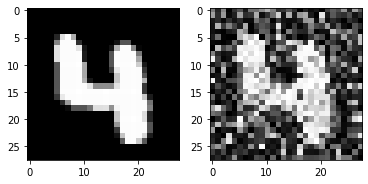

25  :  0.3791230489137307 25
50  :  0.5825470619536508 25
75  :  0.59520710003537 25
100  :  0.6082746932121635 25
125  :  0.6082746932121635 25
150  :  0.6082746932121635 25
175  :  0.6082746932121635 25
200  :  0.6082746932121635 25
225  :  0.6113854394280613 25
250  :  0.6101489300133691 25
275  :  0.6112245519884985 25
300  :  0.6108693677169367 25
325  :  0.6116303171763001 25
350  :  0.613781778308785 25
375  :  0.613781778308785 25
400  :  0.6139653304149361 25
425  :  0.6151188758775311 25
450  :  0.6155915778880469 25
475  :  0.6188824386593488 25
500  :  0.6186525985242497 25
525  :  0.6197987394669785 25
550  :  0.6197987394669785 25
575  :  0.6197987394669785 25
600  :  0.6197987394669785 25
625  :  0.6205662877285981 25
650  :  0.6205662877285981 25
675  :  0.6218587592561331 25
700  :  0.6218447807308106 25
725  :  0.6218447807308106 25
750  :  0.6227317365756512 25
775  :  0.6228035648588451 25
800  :  0.6229607129965264 25
825  :  0.6244725290390102 25
850  :  0.6244630

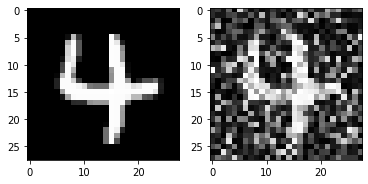

25  :  0.3946886387368696 25
50  :  0.5988983957283304 25
75  :  0.5903844484117862 25
100  :  0.5926245257285997 25
125  :  0.5950676492856125 25
150  :  0.5950676492856125 25
175  :  0.5950676492856125 25
200  :  0.5950676492856125 25
225  :  0.5973902951285491 25
250  :  0.5980247358467843 25
275  :  0.5982087575362136 25
300  :  0.6015845485798403 25
325  :  0.6023498673469125 25
350  :  0.6023498673469125 25
375  :  0.6023498673469125 25
400  :  0.6023498673469125 25
425  :  0.6046791135946843 25
450  :  0.6052444954780677 25
475  :  0.6058090122638905 25
500  :  0.6057879190476516 25
525  :  0.6071948517883844 25
550  :  0.6081090267369594 25
575  :  0.6081090267369594 25
600  :  0.6083363006650112 25
625  :  0.6083041584272264 25
650  :  0.6094248734619621 25
675  :  0.6102473060647199 25
700  :  0.6102477622778663 25
725  :  0.6108105110915486 25
750  :  0.6107977204677958 25
775  :  0.6114872910964669 25
800  :  0.6127338976804461 25
825  :  0.6127325973116029 25
Time:  48.117

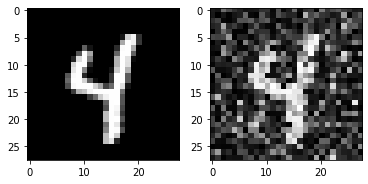

25  :  0.569149250315471 25
50  :  0.5951090098207893 25
75  :  0.5960756693418416 25
100  :  0.5960756693418416 25
125  :  0.5972045323517482 25
150  :  0.5972045323517482 25
175  :  0.5972045323517482 25
200  :  0.5972045323517482 25
225  :  0.5972045323517482 25
250  :  0.5972045323517482 25
275  :  0.5972045323517482 25
300  :  0.5972045323517482 25
325  :  0.5972045323517482 25
350  :  0.598761802836931 25
375  :  0.5984148134480094 25
400  :  0.5985473029048394 25
425  :  0.5984401149949339 25
450  :  0.598474766922637 25
475  :  0.5997217905271804 25
500  :  0.5996036637440333 25
525  :  0.6025962331076684 25
550  :  0.6037678139451192 25
575  :  0.6037683295846644 25
600  :  0.6037683295846644 25
625  :  0.6037683295846644 25
650  :  0.6037683295846644 25
675  :  0.6037683295846644 25
700  :  0.6037683295846644 25
725  :  0.6038650463335495 25
750  :  0.604478967388463 25
775  :  0.604500088381457 25
800  :  0.604500088381457 25
825  :  0.6061246151531889 25
Time:  52.386052370

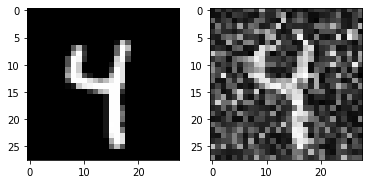

25  :  0.600288356295112 25
50  :  0.600288356295112 25
75  :  0.6010414562276105 25
100  :  0.6008238338025325 25
125  :  0.6008238338025325 25
150  :  0.6008238338025325 25
175  :  0.6008238338025325 25
200  :  0.6008238338025325 25
225  :  0.6008238338025325 25
250  :  0.6032628212852692 25
275  :  0.6029279107813471 25
300  :  0.6056006485974684 25
325  :  0.6056006485974684 25
350  :  0.6069020962649505 25
375  :  0.6069709312053239 25
400  :  0.6081996782955224 25
425  :  0.6083430691161229 25
450  :  0.6089644203714887 25
475  :  0.610531175957951 25
500  :  0.6112020931656108 25
525  :  0.6116663664707871 25
550  :  0.6129155848377951 25
575  :  0.6131145050607161 25
600  :  0.613131982580087 25
625  :  0.6146083437066353 25
650  :  0.6146070889451298 25
675  :  0.6150476492430498 25
700  :  0.6158145368281862 25
725  :  0.6158102092575028 25
750  :  0.6165141720223305 25
775  :  0.6165140826153633 25
800  :  0.6165140826153633 25
Time:  48.32206392288208  seconds
Predicted cla

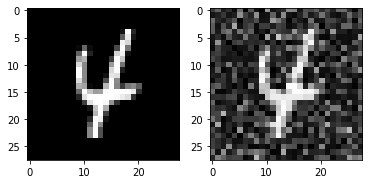

25  :  0.5856625223437282 25
50  :  0.5870629355351044 25
75  :  0.5980801588525038 25
100  :  0.5980801588525038 25
125  :  0.5980801588525038 25
150  :  0.5980801588525038 25
175  :  0.5980801588525038 25
200  :  0.5989816963975664 25
225  :  0.5989816963975664 25
250  :  0.602330693851044 25
275  :  0.6026047297010206 25
300  :  0.6023082608112131 25
325  :  0.6042692184040814 25
350  :  0.6051155979589294 25
375  :  0.6065537551376007 25
400  :  0.6084222019749015 25
425  :  0.6085593452581182 25
450  :  0.608841574203587 25
475  :  0.6102177509207606 25
500  :  0.6115866287813574 25
525  :  0.6119370213223863 25
550  :  0.6135818015937754 25
575  :  0.6157125802221957 25
600  :  0.6157166393646699 25
625  :  0.6168284445452052 25
650  :  0.6168389828561317 25
675  :  0.6168218343891029 25
700  :  0.6177076752861088 25
725  :  0.6177076752861088 25
750  :  0.6177076752861088 25
775  :  0.6179914689533701 25
800  :  0.618106326327742 25
825  :  0.6181296500603852 25
850  :  0.618721

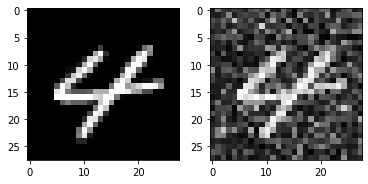

25  :  0.6039859609079409 25
50  :  0.6039859609079409 25
75  :  0.6079846988181354 25
100  :  0.6079846988181354 25
125  :  0.6082918965354591 25
150  :  0.6082918965354591 25
175  :  0.6085417891464897 25
200  :  0.6117465939086836 25
225  :  0.611451847530206 25
250  :  0.611451847530206 25
275  :  0.611451847530206 25
300  :  0.6115102755487144 25
325  :  0.6115102755487144 25
350  :  0.6115102755487144 25
375  :  0.6125189951244528 25
400  :  0.6131596668384177 25
425  :  0.6160685109428854 25
450  :  0.616061732062563 25
475  :  0.616061732062563 25
500  :  0.6172002844684346 25
525  :  0.6182780269989687 25
550  :  0.6190380902106495 25
575  :  0.619440491439822 25
600  :  0.6215768985727598 25
625  :  0.6214329951684349 25
650  :  0.6214329951684349 25
675  :  0.6214329951684349 25
700  :  0.6214329951684349 25
725  :  0.6219606064262786 25
750  :  0.6219606064262786 25
775  :  0.6235641261232393 25
800  :  0.6235641261232393 25
Time:  56.06516623497009  seconds
Predicted class

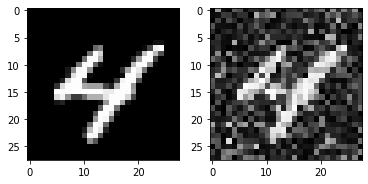

25  :  0.5904589869201529 25
50  :  0.5904589869201529 25
75  :  0.5905734698772395 25
100  :  0.591955904387893 25
125  :  0.5921247348633315 25
150  :  0.592224076369778 25
175  :  0.5936416883946909 25
200  :  0.5965006781968261 25
225  :  0.5964925203575498 25
250  :  0.5964925203575498 25
275  :  0.5973190966574388 25
300  :  0.5973790035358781 25
325  :  0.5993646222727502 25
350  :  0.5993220965631882 25
375  :  0.5993220965631882 25
400  :  0.6000605644785981 25
425  :  0.6004250604972772 25
450  :  0.6011693668030796 25
475  :  0.601162331761802 25
500  :  0.6020313350486337 25
525  :  0.6026173337113158 25
550  :  0.6026173337113158 25
575  :  0.6029561241441291 25
600  :  0.6033019481639152 25
625  :  0.6033108193385882 25
650  :  0.6033548289363511 25
675  :  0.6037787349396451 25
700  :  0.6040393655412255 25
725  :  0.6041124707734051 25
750  :  0.6045566969611522 25
775  :  0.6045566969611522 25
800  :  0.6046433546140542 25
Time:  50.73194766044617  seconds
Predicted cl

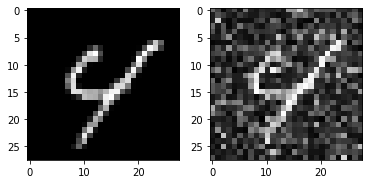

25  :  0.2779137492432242 25
50  :  0.5483105246905384 25
75  :  0.5931151879798591 25
100  :  0.5895212943804354 25
125  :  0.5953430825506427 25
150  :  0.5953430825506427 25
175  :  0.5954040004968061 25
200  :  0.5953981505485043 25
225  :  0.5953981505485043 25
250  :  0.5953981505485043 25
275  :  0.5953981505485043 25
300  :  0.5959091756201036 25
325  :  0.5979564515976598 25
350  :  0.5980699683925371 25
375  :  0.5980699683925371 25
400  :  0.5980699683925371 25
425  :  0.5980699683925371 25
450  :  0.5980699683925371 25
475  :  0.5985227005492051 25
500  :  0.5988426719495972 25
525  :  0.6001861050451168 25
550  :  0.6001861050451168 25
575  :  0.6006882417605961 25
600  :  0.6011881515696322 25
625  :  0.6034419347808901 25
650  :  0.6034328756284868 25
675  :  0.6034328756284868 25
700  :  0.6045684842512417 25
725  :  0.6045724667098409 25
750  :  0.6047804521009248 25
775  :  0.6048033688879205 25
800  :  0.6055396942234462 25
825  :  0.6055327491972639 25
850  :  0.605

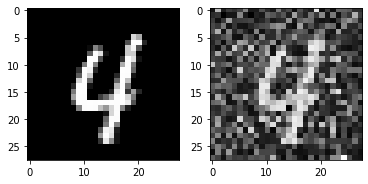

25  :  0.6039942251199171 25
50  :  0.6039942251199171 25
75  :  0.5997931458333456 25
100  :  0.5984735794465809 25
125  :  0.6010123714556782 25
150  :  0.6010123714556782 25
175  :  0.6010123714556782 25
200  :  0.6010123714556782 25
225  :  0.6010123714556782 25
250  :  0.6010123714556782 25
275  :  0.6010123714556782 25
300  :  0.6010123714556782 25
325  :  0.6010123714556782 25
350  :  0.6010123714556782 25
375  :  0.6010123714556782 25
400  :  0.6010123714556782 25
425  :  0.6010123714556782 25
450  :  0.6010123714556782 25
475  :  0.6015053665350243 25
500  :  0.6015053665350243 25
525  :  0.6033942388873035 25
550  :  0.6049371971931351 25
575  :  0.6055835509917745 25
600  :  0.6059221050452049 25
625  :  0.6062717280336417 25
650  :  0.6062717280336417 25
675  :  0.6062717280336417 25
700  :  0.6074012586018245 25
725  :  0.6076346818666729 25
750  :  0.6084746111756074 25
775  :  0.6088166299582678 25
800  :  0.6093307291092943 25
Time:  52.84290027618408  seconds
Predicted

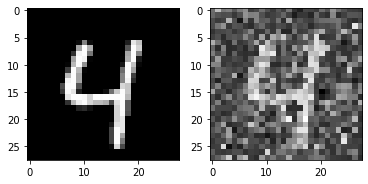

25  :  0.5807430027462798 25
50  :  0.5815496953911545 25
75  :  0.5813819739814167 25
100  :  0.585216483048182 25
125  :  0.5833278615739081 25
150  :  0.5833278615739081 25
175  :  0.5833278615739081 25
200  :  0.5854366771088939 25
225  :  0.5877538423269194 25
250  :  0.5877538423269194 25
275  :  0.5877538423269194 25
300  :  0.5883755662856719 25
325  :  0.5883947601406763 25
350  :  0.5886648239277327 25
375  :  0.5886648239277327 25
400  :  0.5886648239277327 25
425  :  0.5900555302762437 25
450  :  0.5907617098255378 25
475  :  0.5907617098255378 25
500  :  0.591107620821001 25
525  :  0.5918662395384369 25
550  :  0.5927612927019968 25
575  :  0.5928788576170985 25
600  :  0.5939200113437869 25
625  :  0.5944917113326458 25
650  :  0.594537709559688 25
675  :  0.595190167448903 25
700  :  0.5953795950734615 25
725  :  0.5954551739932652 25
750  :  0.5958511280151192 25
775  :  0.5959478121571551 25
800  :  0.596191639351496 25
Time:  53.30152487754822  seconds
Predicted clas

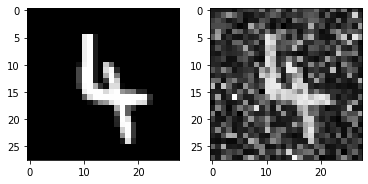

25  :  0.5748036752963176 25
50  :  0.5748036752963176 25
75  :  0.576524400449027 25
100  :  0.5766994131638288 25
125  :  0.5766994131638288 25
150  :  0.5766994131638288 25
175  :  0.5789430493017477 25
200  :  0.5789430493017477 25
225  :  0.5789430493017477 25
250  :  0.5789430493017477 25
275  :  0.5815231226063661 25
300  :  0.5836043774203465 25
325  :  0.5836772163281502 25
350  :  0.5836772163281502 25
375  :  0.5836772163281502 25
400  :  0.5845645810047748 25
425  :  0.5845276786670515 25
450  :  0.5845554230037321 25
475  :  0.5845661586755685 25
500  :  0.5845666997188824 25
525  :  0.584644904758656 25
550  :  0.5852507242111736 25
575  :  0.5867668175392593 25
600  :  0.5869889680317903 25
625  :  0.5869889680317903 25
650  :  0.5879290928284684 25
675  :  0.5879863547409978 25
700  :  0.5880794534994451 25
725  :  0.5884342552047997 25
750  :  0.5884341359955102 25
775  :  0.5888218906289883 25
800  :  0.5890617687154832 25
Time:  51.94262099266052  seconds
Predicted c

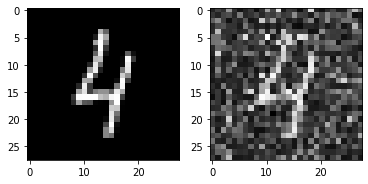

25  :  0.5750233544607863 25
50  :  0.5750233544607863 25
75  :  0.5750233544607863 25
100  :  0.5750233544607863 25
125  :  0.5750233544607863 25
150  :  0.5750233544607863 25
175  :  0.5750233544607863 25
200  :  0.5750233544607863 25
225  :  0.5750233544607863 25
250  :  0.5750233544607863 25
275  :  0.5750233544607863 25
300  :  0.5750233544607863 25
325  :  0.5756301493405053 25
350  :  0.5753319428612348 25
375  :  0.5753319428612348 25
400  :  0.5770274241190751 25
425  :  0.5770428915243944 25
450  :  0.5797172053640525 25
475  :  0.5795848401798831 25
500  :  0.5805620915410218 25
525  :  0.5805346448698989 25
550  :  0.5805346448698989 25
575  :  0.5819775904292036 25
600  :  0.5819517419603363 25
625  :  0.582024942054307 25
650  :  0.5822314964497395 25
675  :  0.5833665314799459 25
700  :  0.5833665314799459 25
725  :  0.5835893698589574 25
750  :  0.5839298471437868 25
775  :  0.5844269824172889 25
800  :  0.5846182363770271 25
Time:  51.900869846343994  seconds
Predicted

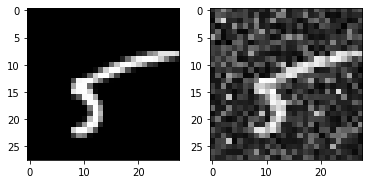

25  :  0.5441240028532442 25
50  :  0.5626569500792135 25
75  :  0.5715056333448645 25
100  :  0.5715056333448645 25
125  :  0.5735219632250673 25
150  :  0.5738450974444752 25
175  :  0.5750960437802525 25
200  :  0.5746515391196055 25
225  :  0.5746515391196055 25
250  :  0.5746515391196055 25
275  :  0.5772899231637602 25
300  :  0.57783935949788 25
325  :  0.5786152712188256 25
350  :  0.5789369215933848 25
375  :  0.5787581986854736 25
400  :  0.5788479132043118 25
425  :  0.5795872350133294 25
450  :  0.5797221001299342 25
475  :  0.5803143310682611 25
500  :  0.5819024787214144 25
525  :  0.5819994717982311 25
550  :  0.5820842734881395 25
575  :  0.5824565849001796 25
600  :  0.5824129502089869 25
625  :  0.5829364317162258 25
650  :  0.5836533598331556 25
675  :  0.5836533598331556 25
700  :  0.5836533598331556 25
725  :  0.5839991309850108 25
750  :  0.5842490185416037 25
775  :  0.5847104213190614 25
800  :  0.5851019263173002 25
825  :  0.5856755657780092 25
Time:  51.56810

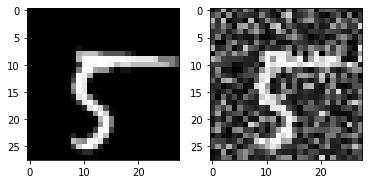

25  :  0.6159312627346967 25
50  :  0.6159312627346967 25
75  :  0.6225507369443403 25
100  :  0.6225507369443403 25
125  :  0.6225507369443403 25
150  :  0.6230015771814307 25
175  :  0.6230701539673464 25
200  :  0.6230701539673464 25
225  :  0.6263330349714539 25
250  :  0.6284872777492777 25
275  :  0.6299972029193494 25
300  :  0.6299972029193494 25
325  :  0.6299972029193494 25
350  :  0.6299972029193494 25
375  :  0.6299972029193494 25
400  :  0.6342272062492439 25
425  :  0.6339277544189895 25
450  :  0.6339277544189895 25
475  :  0.6339277544189895 25
500  :  0.6339277544189895 25
525  :  0.6339277544189895 25
550  :  0.6339866882132388 25
575  :  0.6346775629131706 25
600  :  0.6362742085621396 25
625  :  0.6369455163043352 25
650  :  0.6368657096557282 25
675  :  0.6373287352810983 25
700  :  0.6375930481871759 25
725  :  0.6381510062926734 25
750  :  0.6381655552565431 25
775  :  0.6387242386342289 25
800  :  0.6390502343266342 25
Time:  52.78173351287842  seconds
Predicted

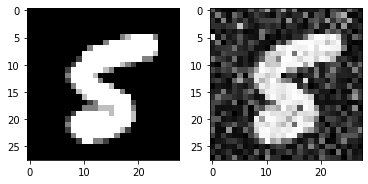

25  :  0.3276936016208112 25
50  :  0.577285404564285 25
75  :  0.5874608351963114 25
100  :  0.6037233357621098 25
125  :  0.604460415120219 25
150  :  0.604460415120219 25
175  :  0.6067659607455449 25
200  :  0.6067659607455449 25
225  :  0.6067659607455449 25
250  :  0.6067659607455449 25
275  :  0.6067659607455449 25
300  :  0.6067659607455449 25
325  :  0.6067659607455449 25
350  :  0.6076286581290289 25
375  :  0.6067659607455449 25
400  :  0.6095814184041656 25
425  :  0.6095814184041656 25
450  :  0.6099246228166193 25
475  :  0.6099246228166193 25
500  :  0.6124934547353621 25
525  :  0.613211536222744 25
550  :  0.6130782035554606 25
575  :  0.613241613319399 25
600  :  0.6132788416948434 25
625  :  0.6132788416948434 25
650  :  0.6132788416948434 25
675  :  0.6144917274529461 25
700  :  0.6144794650839809 25
725  :  0.6154957812018282 25
750  :  0.6159607824525197 25
775  :  0.6180788454948559 25
800  :  0.6181369061238775 25
825  :  0.6186079430907814 25
850  :  0.61886621

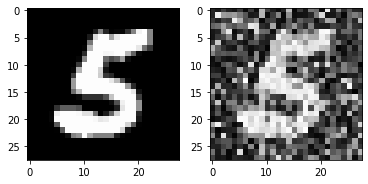

25  :  0.6049590226073411 25
50  :  0.6125044811729083 25
75  :  0.6196362428306822 25
100  :  0.6225430767769781 25
125  :  0.6227555863682345 25
150  :  0.6225430767769781 25
175  :  0.6242030674696204 25
200  :  0.624416856554549 25
225  :  0.6244276352550708 25
250  :  0.6273873795156637 25
275  :  0.6278517346772559 25
300  :  0.6293842193994328 25
325  :  0.6294647357216454 25
350  :  0.6294647357216454 25
375  :  0.6303891292246615 25
400  :  0.6304023248032279 25
425  :  0.6304023248032279 25
450  :  0.6304023248032279 25
475  :  0.6304023248032279 25
500  :  0.6304023248032279 25
525  :  0.6304023248032279 25
550  :  0.6311394831584081 25
575  :  0.6312304180264015 25
600  :  0.6315418130282611 25
625  :  0.6316784230827456 25
650  :  0.6329127538678787 25
675  :  0.6344186890036834 25
700  :  0.6342864636840582 25
725  :  0.6342864636840582 25
750  :  0.6343510097609537 25
775  :  0.6361780996443067 25
800  :  0.6378244834332385 25
Time:  46.101582288742065  seconds
Predicted

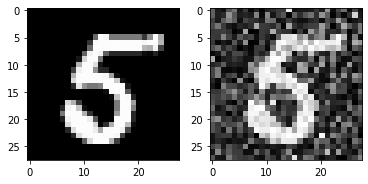

25  :  0.5959073741342584 25
50  :  0.5959073741342584 25
75  :  0.5959073741342584 25
100  :  0.602425795384736 25
125  :  0.602425795384736 25
150  :  0.602425795384736 25
175  :  0.602425795384736 25
200  :  0.602425795384736 25
225  :  0.602425795384736 25
250  :  0.602425795384736 25
275  :  0.602425795384736 25
300  :  0.602425795384736 25
325  :  0.602425795384736 25
350  :  0.6032435719274666 25
375  :  0.6032435719274666 25
400  :  0.6036760101600729 25
425  :  0.6054016644055228 25
450  :  0.6057151764643779 25
475  :  0.6057151764643779 25
500  :  0.6058323540109767 25
525  :  0.6061595002984921 25
550  :  0.6061585392044702 25
575  :  0.6061585392044702 25
600  :  0.6066070823386072 25
625  :  0.6069415881332532 25
650  :  0.6069415881332532 25
675  :  0.6090206671868368 25
700  :  0.6097075868666106 25
725  :  0.6097075868666106 25
750  :  0.6125875881947875 25
775  :  0.6130477784580317 25
800  :  0.6131782641165846 25
Time:  49.440282583236694  seconds
Predicted class:  

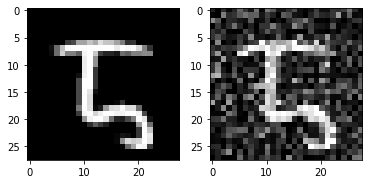

25  :  0.6156440065521744 25
50  :  0.6156440065521744 25
75  :  0.6156440065521744 25
100  :  0.6156440065521744 25
125  :  0.6156440065521744 25
150  :  0.6156440065521744 25
175  :  0.6170123410238793 25
200  :  0.6170187152718561 25
225  :  0.6183414427162309 25
250  :  0.6177285795099016 25
275  :  0.6177285795099016 25
300  :  0.6177285795099016 25
325  :  0.6177285795099016 25
350  :  0.6184467562714316 25
375  :  0.6186085473873979 25
400  :  0.6189936420363815 25
425  :  0.6188273678363754 25
450  :  0.6188273678363754 25
475  :  0.6199982539573727 25
500  :  0.6197417773662895 25
525  :  0.6197417773662895 25
550  :  0.6197867631009855 25
575  :  0.6197867631009855 25
600  :  0.6200726049630075 25
625  :  0.6209057021392912 25
650  :  0.621008326149143 25
675  :  0.621008326149143 25
700  :  0.6217358745682832 25
725  :  0.6217358745682832 25
750  :  0.6217358745682832 25
775  :  0.6217358745682832 25
800  :  0.6217358745682832 25
Time:  48.06905174255371  seconds
Predicted c

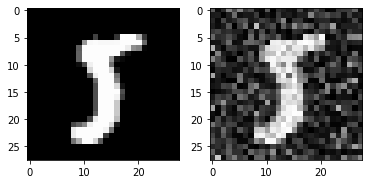

25  :  0.5827570190429991 25
50  :  0.5827570190429991 25
75  :  0.5827570190429991 25
100  :  0.5827570190429991 25
125  :  0.5827570190429991 25
150  :  0.5827570190429991 25
175  :  0.5827570190429991 25
200  :  0.5827570190429991 25
225  :  0.5861186093614721 25
250  :  0.5842640478739227 25
275  :  0.5868243048648459 25
300  :  0.5868243048648459 25
325  :  0.5887747439184312 25
350  :  0.5890599212292176 25
375  :  0.5890599212292176 25
400  :  0.5890599212292176 25
425  :  0.5904129700685876 25
450  :  0.5905687643153339 25
475  :  0.5904506302096943 25
500  :  0.5904506302096943 25
525  :  0.5915875182707104 25
550  :  0.5920481288391223 25
575  :  0.5930071357824501 25
600  :  0.5930071357824501 25
625  :  0.5930071357824501 25
650  :  0.5940300888383268 25
675  :  0.5948068533122514 25
700  :  0.5948052744355916 25
725  :  0.5948052744355916 25
750  :  0.5951159830037511 25
775  :  0.595414742241232 25
800  :  0.5964643556152002 25
Time:  47.73625135421753  seconds
Predicted 

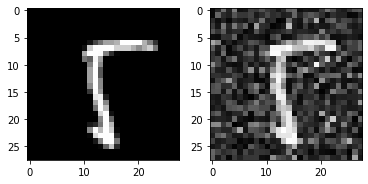

25  :  0.5777814348190717 25
50  :  0.5833709064603366 25
75  :  0.5931591897175148 25
100  :  0.5931591897175148 25
125  :  0.5931591897175148 25
150  :  0.5931591897175148 25
175  :  0.5931591897175148 25
200  :  0.5950050626471497 25
225  :  0.5953040539273937 25
250  :  0.5954563500180985 25
275  :  0.5956453387525376 25
300  :  0.5956453387525376 25
325  :  0.5974735392164588 25
350  :  0.5981424025885416 25
375  :  0.5982281698256029 25
400  :  0.598893169509479 25
425  :  0.598860886834689 25
450  :  0.5998869862558402 25
475  :  0.6006421778018091 25
500  :  0.6042483984098154 25
525  :  0.604829370392313 25
550  :  0.604829370392313 25
575  :  0.6057324843176983 25
600  :  0.6058943025195652 25
625  :  0.6064576277291485 25
650  :  0.6064324908866929 25
675  :  0.6079142141955836 25
700  :  0.608535388464118 25
725  :  0.6085336230924272 25
750  :  0.6088978483836076 25
775  :  0.6097575395911267 25
800  :  0.6097575395911267 25
Time:  45.04816389083862  seconds
Predicted clas

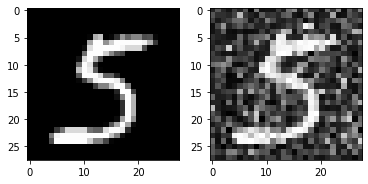

25  :  0.6064525649291265 25
50  :  0.6064525649291265 25
75  :  0.6139322277270266 25
100  :  0.6139322277270266 25
125  :  0.6139322277270266 25
150  :  0.6139322277270266 25
175  :  0.6145765635425663 25
200  :  0.6157451012117655 25
225  :  0.6186324858049663 25
250  :  0.6186324858049663 25
275  :  0.6204877918267782 25
300  :  0.6214598156015863 25
325  :  0.6214598156015863 25
350  :  0.6235590593891913 25
375  :  0.6235590593891913 25
400  :  0.6251750009292033 25
425  :  0.6251750009292033 25
450  :  0.6252396621662477 25
475  :  0.6252315456753577 25
500  :  0.6260268740257935 25
525  :  0.6265764937052967 25
550  :  0.6272870831774068 25
575  :  0.6273189337056976 25
600  :  0.6282590806733579 25
625  :  0.62825344325333 25
650  :  0.6291237067093338 25
675  :  0.629145003687005 25
700  :  0.629145003687005 25
725  :  0.629145003687005 25
750  :  0.629145003687005 25
775  :  0.6292504659264537 25
800  :  0.629398996678426 25
Time:  47.39725422859192  seconds
Predicted class:

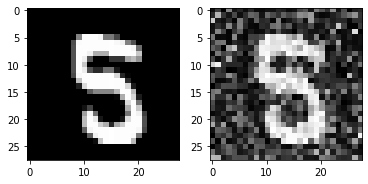

25  :  0.5722197087435222 25
50  :  0.5842140172434417 25
75  :  0.5880008031517785 25
100  :  0.588503774446191 25
125  :  0.588503774446191 25
150  :  0.588503774446191 25
175  :  0.588503774446191 25
200  :  0.588503774446191 25
225  :  0.588503774446191 25
250  :  0.588503774446191 25
275  :  0.588503774446191 25
300  :  0.588503774446191 25
325  :  0.588503774446191 25
350  :  0.589950073768537 25
375  :  0.5898637905955217 25
400  :  0.5898637905955217 25
425  :  0.5915680211518983 25
450  :  0.5915680211518983 25
475  :  0.5917870503714608 25
500  :  0.5922378997172669 25
525  :  0.5928700929386197 25
550  :  0.5928385368642888 25
575  :  0.5932993174116311 25
600  :  0.5939722488138873 25
625  :  0.5939722488138873 25
650  :  0.5951179177467879 25
675  :  0.5951016443116621 25
700  :  0.5954748808532253 25
725  :  0.595437734702059 25
750  :  0.5959422078378755 25
775  :  0.5961247642262458 25
800  :  0.5961267487701776 25
825  :  0.5963787310406417 25
Time:  52.033228158950806

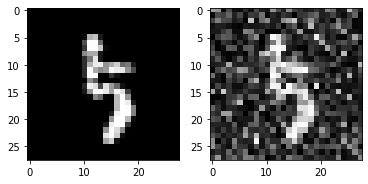

25  :  0.6081694353470903 25
50  :  0.6081694353470903 25
75  :  0.6081694353470903 25
100  :  0.6120335257422467 25
125  :  0.6120335257422467 25
150  :  0.6120335257422467 25
175  :  0.6120335257422467 25
200  :  0.6139058327956098 25
225  :  0.61381008781589 25
250  :  0.61381008781589 25
275  :  0.61381008781589 25
300  :  0.61381008781589 25
325  :  0.61381008781589 25
350  :  0.61381008781589 25
375  :  0.61381008781589 25
400  :  0.61381008781589 25
425  :  0.61381008781589 25
450  :  0.615498906163097 25
475  :  0.6152126900810099 25
500  :  0.6164533718733829 25
525  :  0.6193490888733383 25
550  :  0.6199424711288559 25
575  :  0.6199424711288559 25
600  :  0.6219346888956809 25
625  :  0.6225105797001725 25
650  :  0.6231623857573236 25
675  :  0.6232071185740689 25
700  :  0.6232189037943572 25
725  :  0.6232205464603096 25
750  :  0.6239873261334921 25
775  :  0.6239928972335498 25
800  :  0.6239928972335498 25
Time:  46.541301012039185  seconds
Predicted class:  [8]


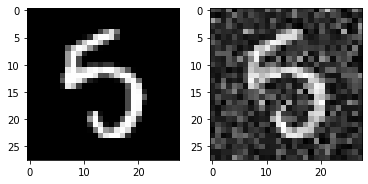

25  :  0.6175669392153432 25
50  :  0.6257954441747436 25
75  :  0.6236289809124481 25
100  :  0.6257301143213708 25
125  :  0.6336666202690977 25
150  :  0.6336666202690977 25
175  :  0.6443136334510582 25
200  :  0.6445367409279161 25
225  :  0.6428397486913152 25
250  :  0.6451280998829231 25
275  :  0.6452563239445244 25
300  :  0.6452563239445244 25
325  :  0.6452563239445244 25
350  :  0.6481893615924041 25
375  :  0.6481893615924041 25
400  :  0.6481893615924041 25
425  :  0.6481893615924041 25
450  :  0.6481893615924041 25
475  :  0.6484859398589597 25
500  :  0.6532586247723786 25
525  :  0.6528330948201396 25
550  :  0.6544635750712087 25
575  :  0.6558295752437863 25
600  :  0.6589571196271715 25
625  :  0.6589560759473424 25
650  :  0.6589560759473424 25
675  :  0.6597786974481068 25
700  :  0.660765150609225 25
725  :  0.660765150609225 25
750  :  0.660765150609225 25
775  :  0.6607723491506062 25
800  :  0.6614920753608254 25
825  :  0.6623311367728073 25
850  :  0.662312

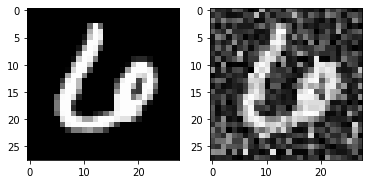

25  :  0.5811322114921087 25
50  :  0.5889532955395298 25
75  :  0.5859295400485107 25
100  :  0.6233665340368032 25
125  :  0.6202941979120131 25
150  :  0.6202941979120131 25
175  :  0.6217125010758329 25
200  :  0.6217030862615043 25
225  :  0.6217030862615043 25
250  :  0.6217030862615043 25
275  :  0.6223186625295984 25
300  :  0.6223971064890114 25
325  :  0.6225629976788326 25
350  :  0.6225629976788326 25
375  :  0.6225629976788326 25
400  :  0.622823275528439 25
425  :  0.622823275528439 25
450  :  0.622823275528439 25
475  :  0.622823275528439 25
500  :  0.6230602432021785 25
525  :  0.6230664266945257 25
550  :  0.622823275528439 25
575  :  0.6253481299964602 25
600  :  0.625864821157324 25
625  :  0.6274821509236262 25
650  :  0.6275084607791018 25
675  :  0.6289838165642663 25
700  :  0.6313997082959019 25
725  :  0.6313997082959019 25
750  :  0.6313997082959019 25
775  :  0.6313997082959019 25
800  :  0.6324715066468843 25
825  :  0.6347559452539389 25
850  :  0.634942619

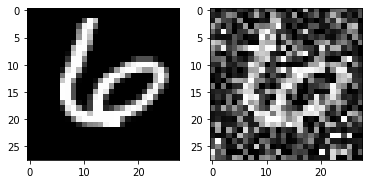

25  :  0.28240627383754424 25
50  :  0.5665156031485578 25
75  :  0.5824042154637992 25
100  :  0.5754826482059796 25
125  :  0.5754826482059796 25
150  :  0.5754826482059796 25
175  :  0.5801954411297197 25
200  :  0.5803596551271404 25
225  :  0.5803596551271404 25
250  :  0.5803596551271404 25
275  :  0.5812713712375961 25
300  :  0.5817206003668534 25
325  :  0.5817206003668534 25
350  :  0.584149451979209 25
375  :  0.584149451979209 25
400  :  0.584149451979209 25
425  :  0.5849841489879871 25
450  :  0.5853014836322896 25
475  :  0.5864275916459702 25
500  :  0.5871774348306433 25
525  :  0.5881824222710982 25
550  :  0.5889161705282189 25
575  :  0.5897602695099953 25
600  :  0.5902239361985383 25
625  :  0.5917034198939265 25
650  :  0.5917034198939265 25
675  :  0.5917034198939265 25
700  :  0.5928279719292545 25
725  :  0.5933384085109182 25
750  :  0.5934441842516064 25
775  :  0.5934441842516064 25
800  :  0.5943796206511844 25
825  :  0.5953242623653359 25
850  :  0.59536

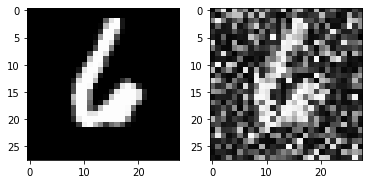

25  :  0.6086311115516385 25
50  :  0.6086311115516385 25
75  :  0.6086311115516385 25
100  :  0.6086311115516385 25
125  :  0.6086311115516385 25
150  :  0.6086311115516385 25
175  :  0.6086311115516385 25
200  :  0.6091778758053163 25
225  :  0.6098079137228446 25
250  :  0.6098079137228446 25
275  :  0.6107061039364376 25
300  :  0.6102201818255144 25
325  :  0.6138180381411877 25
350  :  0.6146930461418874 25
375  :  0.6146930461418874 25
400  :  0.6162732262390296 25
425  :  0.6146930461418874 25
450  :  0.6146930461418874 25
475  :  0.6149655874808356 25
500  :  0.6168395687986918 25
525  :  0.6169327204458056 25
550  :  0.6181694615600699 25
575  :  0.6181694615600699 25
600  :  0.6181694615600699 25
625  :  0.6201939030346605 25
650  :  0.6201939113154542 25
675  :  0.6208900261649052 25
700  :  0.6225331972234411 25
725  :  0.6226370620337148 25
750  :  0.6228052425601165 25
775  :  0.6228586398125189 25
800  :  0.624378558720855 25
Time:  51.04786229133606  seconds
Predicted 

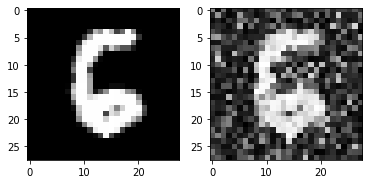

25  :  0.592660622670849 25
50  :  0.592660622670849 25
75  :  0.599711773243368 25
100  :  0.6015340424982281 25
125  :  0.6015340424982281 25
150  :  0.6016126524128569 25
175  :  0.6016126524128569 25
200  :  0.6042636410962292 25
225  :  0.6042636410962292 25
250  :  0.6042636410962292 25
275  :  0.6050447344438449 25
300  :  0.6054616013496396 25
325  :  0.6099294033009042 25
350  :  0.6099294033009042 25
375  :  0.6099294033009042 25
400  :  0.6099294033009042 25
425  :  0.6099294033009042 25
450  :  0.6099294033009042 25
475  :  0.6099294033009042 25
500  :  0.6106654327233694 25
525  :  0.6106654327233694 25
550  :  0.6127499630173564 25
575  :  0.6129010333051857 25
600  :  0.6132817234161555 25
625  :  0.6140437846580786 25
650  :  0.6159985988991248 25
675  :  0.6159977357500631 25
700  :  0.6162080069749744 25
725  :  0.6164517050723629 25
750  :  0.6172113407968088 25
775  :  0.6174831988220998 25
800  :  0.617748653380878 25
Time:  44.47392821311951  seconds
Predicted cla

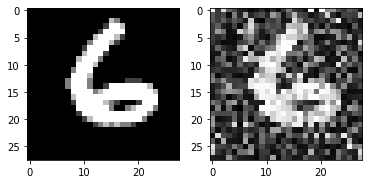

25  :  0.6057278789949121 25
50  :  0.6057278789949121 25
75  :  0.6132638173355056 25
100  :  0.6132638173355056 25
125  :  0.6132638173355056 25
150  :  0.6132638173355056 25
175  :  0.6167935723947576 25
200  :  0.6167935723947576 25
225  :  0.6167935723947576 25
250  :  0.6167935723947576 25
275  :  0.6167935723947576 25
300  :  0.6215443875716897 25
325  :  0.6217220624289906 25
350  :  0.6242026890136918 25
375  :  0.6242026890136918 25
400  :  0.626794287684432 25
425  :  0.6275334210711185 25
450  :  0.6275587437794645 25
475  :  0.6295041721070509 25
500  :  0.6295041721070509 25
525  :  0.6296242322276586 25
550  :  0.6302172886433444 25
575  :  0.6315502013637555 25
600  :  0.6314459643195277 25
625  :  0.6333497683329598 25
650  :  0.6332839266244091 25
675  :  0.6337656132233009 25
700  :  0.6348645582314968 25
725  :  0.6349024009433378 25
750  :  0.6348983459087467 25
775  :  0.6360867003174249 25
800  :  0.6362095881160837 25
Time:  44.71437883377075  seconds
Predicted 

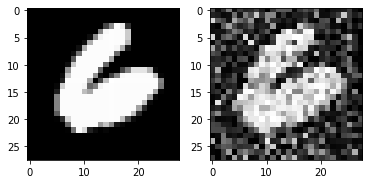

25  :  0.631254422595893 25
50  :  0.631254422595893 25
75  :  0.6361437458981103 25
100  :  0.6373687270817878 25
125  :  0.6384246326941493 25
150  :  0.6384246326941493 25
175  :  0.6384246326941493 25
200  :  0.6384246326941493 25
225  :  0.6384246326941493 25
250  :  0.6400034147711819 25
275  :  0.6400034147711819 25
300  :  0.6408415466350049 25
325  :  0.6420152637575907 25
350  :  0.6420152637575907 25
375  :  0.6439306289679383 25
400  :  0.6457239362025274 25
425  :  0.6462690305327485 25
450  :  0.6462690305327485 25
475  :  0.6462690305327485 25
500  :  0.6478104267289209 25
525  :  0.6493689370669044 25
550  :  0.6493674538308998 25
575  :  0.6493674538308998 25
600  :  0.6503385809515758 25
625  :  0.6518480801160982 25
650  :  0.6518530315610195 25
675  :  0.6518530315610195 25
700  :  0.6522344335032433 25
725  :  0.6522344335032433 25
750  :  0.6522408939049666 25
775  :  0.6522408939049666 25
800  :  0.6522408939049666 25
Time:  45.43886709213257  seconds
Predicted c

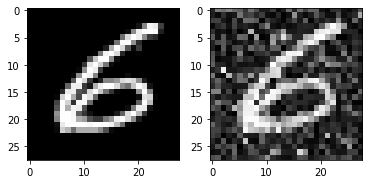

25  :  0.6233401960995528 25
50  :  0.6233401960995528 25
75  :  0.6252191573588437 25
100  :  0.6271466534211021 25
125  :  0.6271990889291326 25
150  :  0.628723757788474 25
175  :  0.6308619572098074 25
200  :  0.6307950149657979 25
225  :  0.6320647096739846 25
250  :  0.6342823014239518 25
275  :  0.6346659345713155 25
300  :  0.6349734764783233 25
325  :  0.6349734764783233 25
350  :  0.6356538649467836 25
375  :  0.6356538649467836 25
400  :  0.6359461344983425 25
425  :  0.6383333131781179 25
450  :  0.6389923442773446 25
475  :  0.6399802620473123 25
500  :  0.6418949418423627 25
525  :  0.6418949418423627 25
550  :  0.6418949418423627 25
575  :  0.6422494311418188 25
600  :  0.6424935007692107 25
625  :  0.6429948963855359 25
650  :  0.6429144166191023 25
675  :  0.6427522443823631 25
700  :  0.6433233425862763 25
725  :  0.6443171829194838 25
750  :  0.6443171829194838 25
775  :  0.6444408338912129 25
800  :  0.6446188236948551 25
Time:  44.7513530254364  seconds
Predicted c

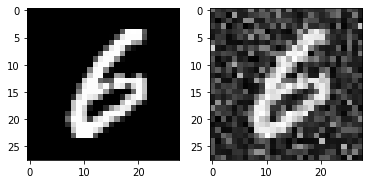

25  :  0.47877295988465013 25
50  :  0.5799117169732102 25
75  :  0.5936520602004381 25
100  :  0.603606036476988 25
125  :  0.60659746964232 25
150  :  0.60659746964232 25
175  :  0.60659746964232 25
200  :  0.60659746964232 25
225  :  0.60659746964232 25
250  :  0.60659746964232 25
275  :  0.60659746964232 25
300  :  0.60659746964232 25
325  :  0.6071126461085703 25
350  :  0.6079792164372049 25
375  :  0.6108726015795543 25
400  :  0.6108726015795543 25
425  :  0.6108726015795543 25
450  :  0.6120242853790244 25
475  :  0.6120028323944132 25
500  :  0.612111548630039 25
525  :  0.6126130652654 25
550  :  0.6130221482487597 25
575  :  0.6134766254931595 25
600  :  0.6141601564457208 25
625  :  0.6141016083029425 25
650  :  0.6146854867302801 25
675  :  0.6147595854187617 25
700  :  0.6151893123372532 25
725  :  0.6152933633769955 25
750  :  0.6158388319247712 25
775  :  0.6164704365421202 25
800  :  0.6166063645115253 25
825  :  0.6166048126561795 25
850  :  0.6166182173986902 25
Tim

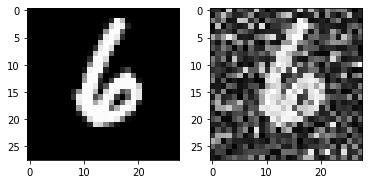

25  :  0.6027673185170929 25
50  :  0.6027673185170929 25
75  :  0.6070753461975558 25
100  :  0.6070753461975558 25
125  :  0.6070753461975558 25
150  :  0.6070753461975558 25
175  :  0.6070753461975558 25
200  :  0.6070753461975558 25
225  :  0.6070753461975558 25
250  :  0.6070753461975558 25
275  :  0.6070753461975558 25
300  :  0.6070753461975558 25
325  :  0.6079173416887543 25
350  :  0.6091324556282266 25
375  :  0.6098906557690451 25
400  :  0.6145775461516889 25
425  :  0.6145775461516889 25
450  :  0.6148244038167023 25
475  :  0.6148244038167023 25
500  :  0.615030531889621 25
525  :  0.6151016931691713 25
550  :  0.6151016931691713 25
575  :  0.6151016931691713 25
600  :  0.6154274336516052 25
625  :  0.617272959083952 25
650  :  0.617272959083952 25
675  :  0.617272959083952 25
700  :  0.617272959083952 25
725  :  0.6178149508245988 25
750  :  0.6178102605243943 25
775  :  0.6178102605243943 25
800  :  0.6178102605243943 25
Time:  45.6092369556427  seconds
Predicted class

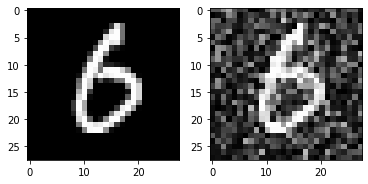

25  :  0.47710888524827744 25
50  :  0.578262382146343 25
75  :  0.5910129258848341 25
100  :  0.5959774403344711 25
125  :  0.5962840329264785 25
150  :  0.5959774403344711 25
175  :  0.5959774403344711 25
200  :  0.5959774403344711 25
225  :  0.5959774403344711 25
250  :  0.59805724969954 25
275  :  0.6029216843417402 25
300  :  0.5967482247119954 25
325  :  0.597138229129693 25
350  :  0.5990401782767113 25
375  :  0.5991320826357018 25
400  :  0.5991320826357018 25
425  :  0.6016161496444165 25
450  :  0.6023259630448089 25
475  :  0.6033571570158671 25
500  :  0.6058649574342893 25
525  :  0.6083231515404329 25
550  :  0.6083231515404329 25
575  :  0.6083231515404329 25
600  :  0.6083231515404329 25
625  :  0.6096512643467192 25
650  :  0.6097509761083947 25
675  :  0.6097491713328825 25
700  :  0.6106936586917637 25
725  :  0.6109216876675012 25
750  :  0.6110116460144723 25
775  :  0.6114505263094003 25
800  :  0.6139185267808608 25
825  :  0.6139185267808608 25
850  :  0.613918

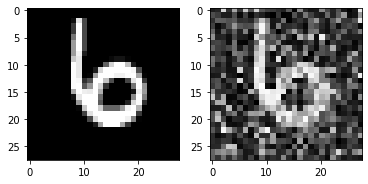

25  :  0.6096809751806133 25
50  :  0.6096809751806133 25
75  :  0.6134129710005027 25
100  :  0.6134129710005027 25
125  :  0.6134129710005027 25
150  :  0.6134129710005027 25
175  :  0.6134129710005027 25
200  :  0.6151999018904993 25
225  :  0.6153465928824471 25
250  :  0.6153431584532429 25
275  :  0.6153431584532429 25
300  :  0.6153431584532429 25
325  :  0.6153431584532429 25
350  :  0.6153431584532429 25
375  :  0.6153431584532429 25
400  :  0.6153431584532429 25
425  :  0.6153431584532429 25
450  :  0.6163413581433584 25
475  :  0.6159326899253992 25
500  :  0.6159326899253992 25
525  :  0.6159326899253992 25
550  :  0.6203785589634849 25
575  :  0.6231288383584009 25
600  :  0.6231288383584009 25
625  :  0.6231288383584009 25
650  :  0.6231288383584009 25
675  :  0.6231288383584009 25
700  :  0.6231288383584009 25
725  :  0.6231288383584009 25
750  :  0.6242435853883763 25
775  :  0.6242565740822178 25
800  :  0.6259135502857769 25
Time:  45.48145890235901  seconds
Predicted

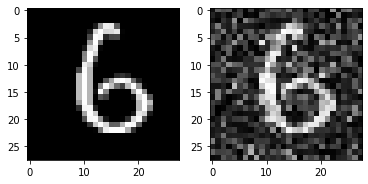

25  :  0.5971122875592633 25
50  :  0.5971122875592633 25
75  :  0.6002191597997383 25
100  :  0.6004558759045837 25
125  :  0.6019307262343995 25
150  :  0.6019307262343995 25
175  :  0.6019307262343995 25
200  :  0.6065242205018002 25
225  :  0.6065242205018002 25
250  :  0.6065242205018002 25
275  :  0.6071332359477444 25
300  :  0.6078281797500658 25
325  :  0.6083866830966087 25
350  :  0.6088288504012236 25
375  :  0.6089509324235376 25
400  :  0.6104903709938349 25
425  :  0.6104903709938349 25
450  :  0.6119226021067605 25
475  :  0.6119226021067605 25
500  :  0.6142839063386977 25
525  :  0.6142839063386977 25
550  :  0.6142839063386977 25
575  :  0.6142839063386977 25
600  :  0.6142839063386977 25
625  :  0.6142839063386977 25
650  :  0.6158959469310096 25
675  :  0.6158638710047674 25
700  :  0.6159037339957636 25
725  :  0.6163341679392113 25
750  :  0.6163614987383839 25
775  :  0.6164174273722471 25
800  :  0.6172510576965067 25
Time:  44.925349950790405  seconds
Predicte

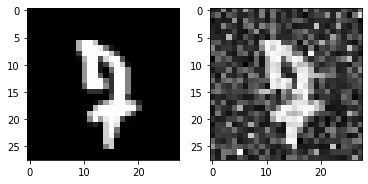

25  :  0.6279400907892811 25
50  :  0.6279400907892811 25
75  :  0.6315007607398523 25
100  :  0.6318715269242573 25
125  :  0.631927751421526 25
150  :  0.6325859906353792 25
175  :  0.6330479011343156 25
200  :  0.6368669843385348 25
225  :  0.6368669843385348 25
250  :  0.6369712863913829 25
275  :  0.6368966379726915 25
300  :  0.6369380097563222 25
325  :  0.6397771078835195 25
350  :  0.6408882816920982 25
375  :  0.6413376246228714 25
400  :  0.6422384909241078 25
425  :  0.6426215788583193 25
450  :  0.6431644021740015 25
475  :  0.6430634173180371 25
500  :  0.6454322938259747 25
525  :  0.6454555750448431 25
550  :  0.6458571601276517 25
575  :  0.6474264197144545 25
600  :  0.6475970747715268 25
625  :  0.6475331890953128 25
650  :  0.6475331890953128 25
675  :  0.6486677368195033 25
700  :  0.6486379102450089 25
725  :  0.6490301730041571 25
750  :  0.6490939699147796 25
775  :  0.649154115748377 25
800  :  0.6500016565367498 25
Time:  47.06643319129944  seconds
Predicted c

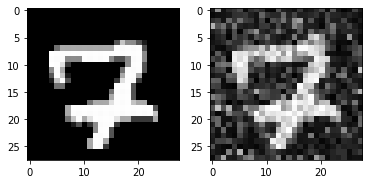

25  :  0.5840221989363568 25
50  :  0.5857481710972574 25
75  :  0.6021143721108385 25
100  :  0.6021143721108385 25
125  :  0.6021143721108385 25
150  :  0.6021143721108385 25
175  :  0.6021143721108385 25
200  :  0.6021143721108385 25
225  :  0.6021143721108385 25
250  :  0.6040781393248207 25
275  :  0.6040781393248207 25
300  :  0.6040781393248207 25
325  :  0.6040781393248207 25
350  :  0.6044331430143053 25
375  :  0.6058749411609196 25
400  :  0.605846312683508 25
425  :  0.6058231048060619 25
450  :  0.6058376805106176 25
475  :  0.6068437098784378 25
500  :  0.6073287815702547 25
525  :  0.6071186410057166 25
550  :  0.6071186410057166 25
575  :  0.608824225185918 25
600  :  0.608824225185918 25
625  :  0.608824225185918 25
650  :  0.6091900208377448 25
675  :  0.6096454696995317 25
700  :  0.6099334350187756 25
725  :  0.609920338529266 25
750  :  0.6103702819536292 25
775  :  0.6104623085335198 25
800  :  0.611231218272519 25
825  :  0.611231218272519 25
850  :  0.6113066765

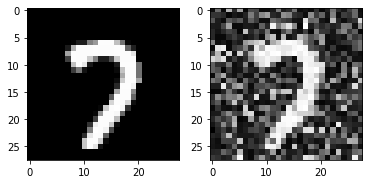

25  :  0.4907914471906323 25
50  :  0.5680156443688247 25
75  :  0.5709459134131774 25
100  :  0.5714327433528803 25
125  :  0.5714327433528803 25
150  :  0.5714327433528803 25
175  :  0.5714327433528803 25
200  :  0.5714327433528803 25
225  :  0.5715068853765515 25
250  :  0.573867536343415 25
275  :  0.5751033643073044 25
300  :  0.5766263517730333 25
325  :  0.5776054551653748 25
350  :  0.5776054551653748 25
375  :  0.577916376880117 25
400  :  0.5787549448835517 25
425  :  0.5793104366615225 25
450  :  0.5798593401022177 25
475  :  0.5805585332404842 25
500  :  0.5823732991378068 25
525  :  0.5838871572250881 25
550  :  0.5840973787073248 25
575  :  0.5855543223046992 25
600  :  0.5857784169112599 25
625  :  0.5856157591608766 25
650  :  0.5863120922892785 25
675  :  0.5864874795674402 25
700  :  0.5864443186847377 25
725  :  0.5867256326952877 25
750  :  0.5872506918983633 25
775  :  0.5877516551407755 25
800  :  0.5886463560226345 25
825  :  0.5891111859842901 25
Time:  47.97970

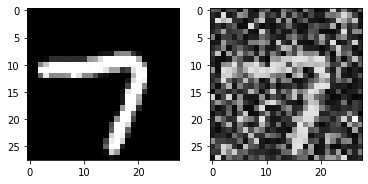

25  :  0.5682973929641771 25
50  :  0.5964003795270337 25
75  :  0.6040398268617032 25
100  :  0.6073005515403488 25
125  :  0.6077088244035879 25
150  :  0.6115815546523214 25
175  :  0.6098896813603639 25
200  :  0.6098896813603639 25
225  :  0.6102930527382462 25
250  :  0.6113913846693013 25
275  :  0.6111487239380737 25
300  :  0.6111487239380737 25
325  :  0.6122912591454722 25
350  :  0.6122594186710574 25
375  :  0.6122594186710574 25
400  :  0.6122594186710574 25
425  :  0.6135273904776584 25
450  :  0.6150810783163085 25
475  :  0.6169199144026677 25
500  :  0.6173180556526331 25
525  :  0.6182660652857175 25
550  :  0.6186154848316376 25
575  :  0.6191237343967809 25
600  :  0.6191806315912316 25
625  :  0.6208098840503385 25
650  :  0.6214074348312596 25
675  :  0.6214419161222924 25
700  :  0.6217488589747948 25
725  :  0.6233738098428191 25
750  :  0.6233738098428191 25
775  :  0.6238181613318676 25
800  :  0.6243487775434836 25
825  :  0.6246006113386596 25
Time:  47.580

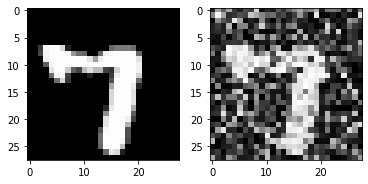

25  :  0.5715783300652967 25
50  :  0.5715783300652967 25
75  :  0.5715783300652967 25
100  :  0.5715783300652967 25
125  :  0.5715783300652967 25
150  :  0.5715783300652967 25
175  :  0.5715783300652967 25
200  :  0.5725182782155567 25
225  :  0.5744557688693142 25
250  :  0.5744557688693142 25
275  :  0.5744557688693142 25
300  :  0.5744557688693142 25
325  :  0.5744557688693142 25
350  :  0.5744557688693142 25
375  :  0.5744557688693142 25
400  :  0.5744557688693142 25
425  :  0.5744557688693142 25
450  :  0.5744557688693142 25
475  :  0.5744557688693142 25
500  :  0.5744557688693142 25
525  :  0.5744557688693142 25
550  :  0.5744557688693142 25
575  :  0.5744557688693142 25
600  :  0.5744557688693142 25
625  :  0.5744557688693142 25
650  :  0.5744557688693142 25
675  :  0.5744557688693142 25
700  :  0.5744557688693142 25
725  :  0.5744557688693142 25
750  :  0.5744557688693142 25
775  :  0.5744557688693142 25
800  :  0.5744557688693142 25
Time:  45.86969447135925  seconds
Predicted

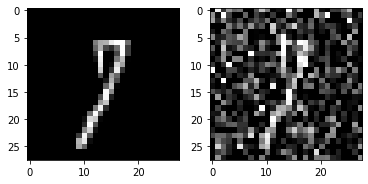

25  :  0.5947178820029572 25
50  :  0.5947178820029572 25
75  :  0.5948536880473109 25
100  :  0.5948536880473109 25
125  :  0.5948536880473109 25
150  :  0.5948536880473109 25
175  :  0.5948536880473109 25
200  :  0.5960642846312599 25
225  :  0.5948536880473109 25
250  :  0.5948536880473109 25
275  :  0.5948536880473109 25
300  :  0.5952698828232874 25
325  :  0.5969941637632512 25
350  :  0.5972265014505285 25
375  :  0.5974129124620544 25
400  :  0.5976154225068169 25
425  :  0.5984504748725168 25
450  :  0.6034350840976943 25
475  :  0.6043173025987707 25
500  :  0.6042609520863959 25
525  :  0.6042609520863959 25
550  :  0.6052387968901604 25
575  :  0.6052387968901604 25
600  :  0.6054447585830877 25
625  :  0.6052387968901604 25
650  :  0.6056775714452065 25
675  :  0.6065171538106824 25
700  :  0.6069469587388859 25
725  :  0.6069469587388859 25
750  :  0.6079990127153029 25
775  :  0.6079990127153029 25
800  :  0.6079990127153029 25
Time:  46.90956211090088  seconds
Predicted

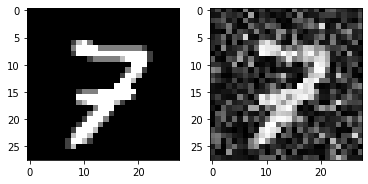

25  :  0.5991920846045045 25
50  :  0.5991920846045045 25
75  :  0.6123305333259845 25
100  :  0.6123305333259845 25
125  :  0.6123305333259845 25
150  :  0.6123305333259845 25
175  :  0.6123305333259845 25
200  :  0.6123305333259845 25
225  :  0.6133665681913483 25
250  :  0.6144936629753036 25
275  :  0.615265843312333 25
300  :  0.6148308915859166 25
325  :  0.6149014258785348 25
350  :  0.6197779784679027 25
375  :  0.6197779784679027 25
400  :  0.6197779784679027 25
425  :  0.6197779784679027 25
450  :  0.6197779784679027 25
475  :  0.6201678729440194 25
500  :  0.6201678729440194 25
525  :  0.6201678729440194 25
550  :  0.6201678729440194 25
575  :  0.6205082768287924 25
600  :  0.6213165349467755 25
625  :  0.623340128671154 25
650  :  0.6234200375562704 25
675  :  0.6240471701199705 25
700  :  0.6249414961251775 25
725  :  0.6266161639090689 25
750  :  0.6276209221928468 25
775  :  0.6281050175870607 25
800  :  0.6281043320531663 25
825  :  0.6283283862734693 25
850  :  0.62879

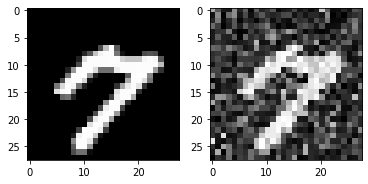

25  :  0.5923421257791941 25
50  :  0.5923421257791941 25
75  :  0.5923421257791941 25
100  :  0.5938685987161174 25
125  :  0.5938685987161174 25
150  :  0.5938685987161174 25
175  :  0.5938685987161174 25
200  :  0.6001520199218336 25
225  :  0.6004828755849453 25
250  :  0.601972291720927 25
275  :  0.6006346165497701 25
300  :  0.6006346165497701 25
325  :  0.6032661611576666 25
350  :  0.6032661611576666 25
375  :  0.6032661611576666 25
400  :  0.6032661611576666 25
425  :  0.6032661611576666 25
450  :  0.6032661611576666 25
475  :  0.6032661611576666 25
500  :  0.604511140828578 25
525  :  0.6053121052692063 25
550  :  0.6052715618148542 25
575  :  0.6061952720558228 25
600  :  0.6061952720558228 25
625  :  0.6061952720558228 25
650  :  0.6070581604310086 25
675  :  0.6083415376950052 25
700  :  0.6083461272526524 25
725  :  0.6083465177989071 25
750  :  0.6086104651410419 25
775  :  0.6086665966291293 25
800  :  0.609445632835746 25
Time:  46.52044486999512  seconds
Predicted cl

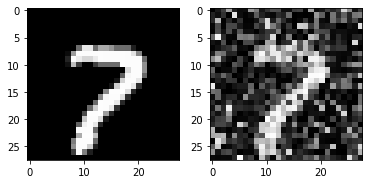

25  :  0.553446618487936 25
50  :  0.5618271650288288 25
75  :  0.57560992428115 25
100  :  0.5796364858125952 25
125  :  0.5796643420096855 25
150  :  0.5843709787775663 25
175  :  0.5798516967306497 25
200  :  0.5798516967306497 25
225  :  0.5800664040661067 25
250  :  0.5806551802248314 25
275  :  0.5820481894205627 25
300  :  0.5820515071088959 25
325  :  0.5820515071088959 25
350  :  0.5825098353749634 25
375  :  0.5826099198610997 25
400  :  0.5849768464164544 25
425  :  0.5855242125457585 25
450  :  0.5869232607391779 25
475  :  0.5869242844797212 25
500  :  0.5869242844797212 25
525  :  0.5869242844797212 25
550  :  0.5880724930782684 25
575  :  0.5880724930782684 25
600  :  0.5890711311383344 25
625  :  0.5890711311383344 25
650  :  0.5905036458384472 25
675  :  0.5906103531103165 25
700  :  0.5906103531103165 25
725  :  0.5917581098003161 25
750  :  0.5917581098003161 25
775  :  0.5922157641044495 25
800  :  0.5925908897922785 25
825  :  0.5925908897922785 25
850  :  0.592787

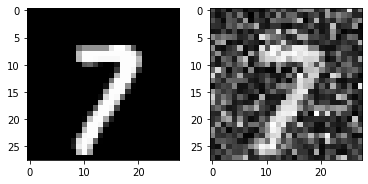

25  :  0.5861119566936384 25
50  :  0.5861119566936384 25
75  :  0.5861119566936384 25
100  :  0.5861119566936384 25
125  :  0.5861119566936384 25
150  :  0.5861119566936384 25
175  :  0.5861119566936384 25
200  :  0.5865375741606923 25
225  :  0.586265821074046 25
250  :  0.5864221893949573 25
275  :  0.5881488783643911 25
300  :  0.5888838484121436 25
325  :  0.59083808053097 25
350  :  0.59083808053097 25
375  :  0.5912831318014495 25
400  :  0.5923809867530125 25
425  :  0.5925451900231845 25
450  :  0.5936458417818844 25
475  :  0.5936458417818844 25
500  :  0.5936458417818844 25
525  :  0.5936458417818844 25
550  :  0.5946040550349648 25
575  :  0.5946731965295118 25
600  :  0.5956225857868953 25
625  :  0.5967718836825294 25
650  :  0.5967676391927187 25
675  :  0.597637598106532 25
700  :  0.5977057151611355 25
725  :  0.5994158971995979 25
750  :  0.5994158971995979 25
775  :  0.5994158971995979 25
800  :  0.5996059471654015 25
Time:  46.20252728462219  seconds
Predicted class

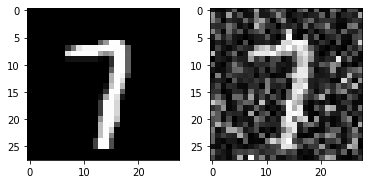

25  :  0.5691781835233846 25
50  :  0.5691781835233846 25
75  :  0.5695608552502545 25
100  :  0.5695608552502545 25
125  :  0.5695608552502545 25
150  :  0.575290582465424 25
175  :  0.5716408700827287 25
200  :  0.5723249314616247 25
225  :  0.5745683543633116 25
250  :  0.5731519225483465 25
275  :  0.5752961290627829 25
300  :  0.5767658505872044 25
325  :  0.5764046784677214 25
350  :  0.5764046784677214 25
375  :  0.5764046784677214 25
400  :  0.5764046784677214 25
425  :  0.5767460872355102 25
450  :  0.5782767083328217 25
475  :  0.5782767083328217 25
500  :  0.5782767083328217 25
525  :  0.5782767083328217 25
550  :  0.5782767083328217 25
575  :  0.5783047933136112 25
600  :  0.578924292606637 25
625  :  0.5797707833405229 25
650  :  0.5797707833405229 25
675  :  0.580015122302736 25
700  :  0.5800610870346719 25
725  :  0.5836226312693729 25
750  :  0.5836226312693729 25
775  :  0.5836226312693729 25
800  :  0.58409595276311 25
Time:  45.76142501831055  seconds
Predicted clas

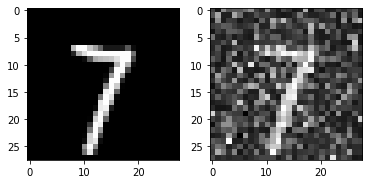

25  :  0.5664978616376648 25
50  :  0.5664978616376648 25
75  :  0.5664978616376648 25
100  :  0.5664978616376648 25
125  :  0.5664978616376648 25
150  :  0.5664978616376648 25
175  :  0.5664978616376648 25
200  :  0.5664978616376648 25
225  :  0.5664978616376648 25
250  :  0.5664978616376648 25
275  :  0.5664978616376648 25
300  :  0.5664978616376648 25
325  :  0.5664978616376648 25
350  :  0.5664978616376648 25
375  :  0.5664978616376648 25
400  :  0.5664978616376648 25
425  :  0.5664978616376648 25
450  :  0.5664978616376648 25
475  :  0.5664978616376648 25
500  :  0.5664978616376648 25
525  :  0.5678860065636245 25
550  :  0.5678860065636245 25
575  :  0.5678860065636245 25
600  :  0.5698593689883842 25
625  :  0.5708951770379749 25
650  :  0.5708951770379749 25
675  :  0.5717379474250378 25
700  :  0.5717378580180706 25
725  :  0.5717865284046948 25
750  :  0.5724371192770259 25
775  :  0.5724314568357722 25
800  :  0.5724702455998232 25
Time:  45.26656937599182  seconds
Predicted

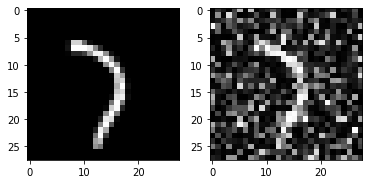

25  :  -0.38312083042220707 25
50  :  -0.38312083042220707 25
75  :  -0.37987687200922365 25
100  :  -0.24828617973594624 25
125  :  -0.12408732195989242 25
150  :  0.397187073034149 25
175  :  0.5428352622953186 25
200  :  0.5642121886524607 25
225  :  0.5683358876113754 25
250  :  0.5752236364135443 25
275  :  0.5751432383862544 25
300  :  0.5751432383862544 25
325  :  0.5751432383862544 25
350  :  0.5752360494513113 25
375  :  0.5779425765449915 25
400  :  0.5808448090697123 25
425  :  0.5810073935831063 25
450  :  0.5810073935831063 25
475  :  0.5837485942984862 25
500  :  0.5842388641409699 25
525  :  0.5868203817330041 25
550  :  0.5872657451018615 25
575  :  0.5872233680430855 25
600  :  0.5893130514092038 25
625  :  0.5893198580090364 25
650  :  0.5906048055045993 25
675  :  0.5905720244816449 25
700  :  0.5905936654622094 25
725  :  0.5914440434773605 25
750  :  0.5921958345509024 25
775  :  0.5921681238850993 25
800  :  0.5928137759904172 25
825  :  0.593790271164854 25
850  

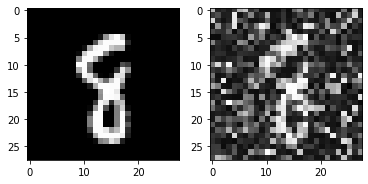

25  :  -0.29659836004310364 25
50  :  0.3003303554694394 25
75  :  0.5767489055461246 25
100  :  0.5723577361474018 25
125  :  0.5193871022122591 25
150  :  0.5774289197915989 25
175  :  0.5615293185193275 25
200  :  0.5761209781338443 25
225  :  0.5632407530844789 25
250  :  0.5838962254750966 25
275  :  0.5834790082472515 25
300  :  0.5865520862880065 25
325  :  0.5865520862880065 25
350  :  0.5865520862880065 25
375  :  0.5865520862880065 25
400  :  0.5865520862880065 25
425  :  0.5865520862880065 25
450  :  0.5865520862880065 25
475  :  0.5865520862880065 25
500  :  0.5876778544699158 25
525  :  0.5865520862880065 25
550  :  0.5865520862880065 25
575  :  0.5880891638259998 25
600  :  0.5882787599954241 25
625  :  0.5892099018681 25
650  :  0.5898470634009827 25
675  :  0.5898470634009827 25
700  :  0.5934886716087752 25
725  :  0.5934890257451294 25
750  :  0.5955591937601308 25
775  :  0.5965409505066989 25
800  :  0.5966687844814608 25
825  :  0.5966687844814608 25
850  :  0.5995

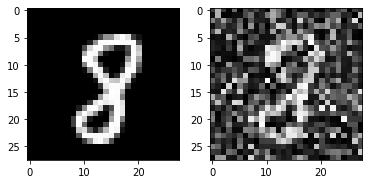

25  :  -0.3486588994235813 25
50  :  -0.3486588994235813 25
75  :  -0.3486588994235813 25
100  :  -0.3486588994235813 25
125  :  -0.3486588994235813 25
150  :  -0.3486588994235813 25
175  :  -0.3475328558199742 25
200  :  -0.3472131415216574 25
225  :  -0.3459950558665799 25
250  :  -0.34481295028343667 25
275  :  -0.34436257997134023 25
300  :  -0.3393737742757098 25
325  :  -0.33938528192107753 25
350  :  -0.33938528192107753 25
375  :  -0.33938528192107753 25
400  :  -0.33831617454873586 25
425  :  -0.33831617454873586 25
450  :  -0.33608891077030034 25
475  :  -0.33608891077030034 25
500  :  -0.33546638800976114 25
525  :  -0.33504719308305553 25
550  :  -0.335044813347271 25
575  :  -0.33482295245030513 25
600  :  -0.334310056759514 25
625  :  -0.334310056759514 25
650  :  -0.334310056759514 25
675  :  -0.334310056759514 25
700  :  -0.3341405397627678 25
725  :  -0.33409422264015426 25
750  :  -0.3340882713520574 25
775  :  -0.3339846334091361 25
800  :  -0.33389987235667373 25
Ti

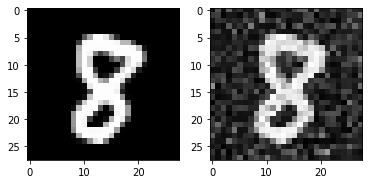

25  :  -0.3582063747024735 25
50  :  -0.3582063747024735 25
75  :  -0.3572276744684592 25
100  :  -0.355348966800915 25
125  :  -0.3488079998817162 25
150  :  -0.344466558704064 25
175  :  -0.3445013934276683 25
200  :  -0.34078738162782446 25
225  :  -0.34078738162782446 25
250  :  -0.34078738162782446 25
275  :  -0.34078738162782446 25
300  :  -0.34078738162782446 25
325  :  -0.34078738162782446 25
350  :  -0.34003471274250896 25
375  :  -0.34003471274250896 25
400  :  -0.34003471274250896 25
425  :  -0.338907037597706 25
450  :  -0.3386139095711398 25
475  :  -0.33757371773513367 25
500  :  -0.337494695984597 25
525  :  -0.33727838975854857 25
550  :  -0.33661705043265644 25
575  :  -0.33643717742659063 25
600  :  -0.33601824029795013 25
625  :  -0.3359812394426515 25
650  :  -0.33565986428423034 25
675  :  -0.3354199385937029 25
700  :  -0.33503268258643654 25
725  :  -0.33503268258643654 25
750  :  -0.33503268258643654 25
775  :  -0.33483888536337003 25
800  :  -0.3347145121722355

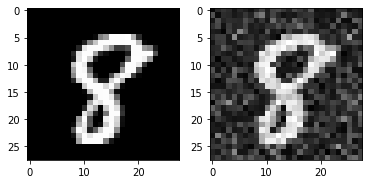

25  :  -0.35760157851751406 25
50  :  -0.35760157851751406 25
75  :  -0.35229052319518334 25
100  :  -0.3520871370259645 25
125  :  -0.35149790538415027 25
150  :  -0.34843020024836224 25
175  :  -0.3482547113444001 25
200  :  -0.3463918306069924 25
225  :  -0.3444048998410295 25
250  :  -0.3444048998410295 25
275  :  -0.3409496240561464 25
300  :  -0.3408335436479193 25
325  :  -0.3408430054343104 25
350  :  -0.34026919476558526 25
375  :  -0.33831182745212607 25
400  :  -0.33715042339586365 25
425  :  -0.33715427215701166 25
450  :  -0.33714442441239545 25
475  :  -0.3368376030886016 25
500  :  -0.3368376030886016 25
525  :  -0.3366440835925546 25
550  :  -0.33650171145799357 25
575  :  -0.3362033197490465 25
600  :  -0.33467577677268134 25
625  :  -0.33467577677268134 25
650  :  -0.33467577677268134 25
675  :  -0.33444535065078596 25
700  :  -0.3344087076863966 25
725  :  -0.3344087076863966 25
750  :  -0.3341413267538569 25
775  :  -0.33414132675385666 25
800  :  -0.333534790910503

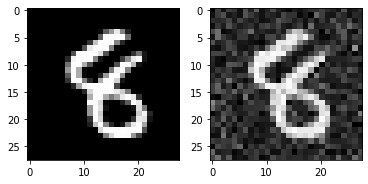

25  :  -0.3524929654438892 25
50  :  -0.3524929654438892 25
75  :  -0.3524929654438892 25
100  :  -0.3494582141556839 25
125  :  -0.3494582141556839 25
150  :  -0.34703379455685446 25
175  :  -0.346583208100802 25
200  :  -0.34671287300606196 25
225  :  -0.3450511256627081 25
250  :  -0.34082867369314385 25
275  :  -0.34084561118789714 25
300  :  -0.34084561118789714 25
325  :  -0.3396475424370181 25
350  :  -0.3380793263326583 25
375  :  -0.3380793263326583 25
400  :  -0.3380793263326583 25
425  :  -0.335932707069321 25
450  :  -0.3359345570403398 25
475  :  -0.3359345570403398 25
500  :  -0.33547051116757215 25
525  :  -0.33547051116757215 25
550  :  -0.33547051116757215 25
575  :  -0.3351143787739767 25
600  :  -0.33499254881595353 25
625  :  -0.3347858156544018 25
650  :  -0.3345169805991277 25
675  :  -0.3343278229860832 25
700  :  -0.33432513532668673 25
725  :  -0.33406598426484635 25
750  :  -0.33406598426484635 25
775  :  -0.3339374868797046 25
800  :  -0.3339374868797046 25
T

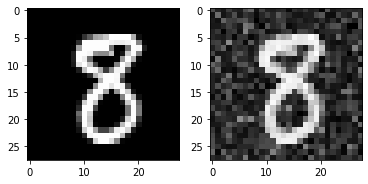

25  :  -0.3658147973428445 25
50  :  -0.3658147973428445 25
75  :  -0.3636524024762221 25
100  :  -0.3563461426190764 25
125  :  -0.35634547048772525 25
150  :  -0.35634547048772525 25
175  :  -0.35634547048772525 25
200  :  -0.35280708389306925 25
225  :  -0.35280708389306925 25
250  :  -0.35280708389306925 25
275  :  -0.35264922295143364 25
300  :  -0.35264966788524865 25
325  :  -0.35264966788524865 25
350  :  -0.35264966788524865 25
375  :  -0.35264966788524865 25
400  :  -0.35224585214993315 25
425  :  -0.3519231098154598 25
450  :  -0.3519362245659845 25
475  :  -0.35085405346203435 25
500  :  -0.35065908695363107 25
525  :  -0.3506635352664338 25
550  :  -0.3506635352664338 25
575  :  -0.3506635352664338 25
600  :  -0.3503536793095422 25
625  :  -0.3498113188125045 25
650  :  -0.34894310675134366 25
675  :  -0.34894310675134366 25
700  :  -0.34893921772739556 25
725  :  -0.34862767334755423 25
750  :  -0.34862767334755423 25
775  :  -0.3484277520623368 25
800  :  -0.347886133900

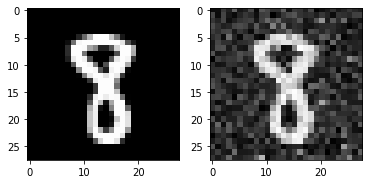

25  :  0.5960141115032932 25
50  :  0.5960141115032932 25
75  :  0.5960141115032932 25
100  :  0.5960141115032932 25
125  :  0.5970820800333063 25
150  :  0.5970820800333063 25
175  :  0.5970820800333063 25
200  :  0.5970820800333063 25
225  :  0.6163254553481552 25
250  :  0.6163254553481552 25
275  :  0.6189247698592641 25
300  :  0.6197729670990727 25
325  :  0.6197729670990727 25
350  :  0.6197729670990727 25
375  :  0.6197729670990727 25
400  :  0.6197729670990727 25
425  :  0.6197729670990727 25
450  :  0.6197729670990727 25
475  :  0.6197729670990727 25
500  :  0.6198778936907695 25
525  :  0.621808297439061 25
550  :  0.6242793185054334 25
575  :  0.6251983152937074 25
600  :  0.6251983152937074 25
625  :  0.6251983152937074 25
650  :  0.6267338591937602 25
675  :  0.6273899582740787 25
700  :  0.6299359816611532 25
725  :  0.6300004156621637 25
750  :  0.6300004156621637 25
775  :  0.6300004156621637 25
800  :  0.6300414906531301 25
825  :  0.630050963687797 25
850  :  0.63019

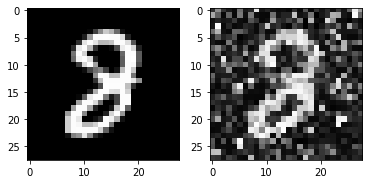

25  :  -0.3346541648977854 25
50  :  -0.3346541648977854 25
75  :  -0.3297524007328451 25
100  :  -0.327471721761174 25
125  :  -0.3271194410794432 25
150  :  -0.322436942507867 25
175  :  -0.32200515048229145 25
200  :  -0.32148948354159745 25
225  :  -0.31712579953844233 25
250  :  -0.31712579953844233 25
275  :  -0.31712579953844233 25
300  :  -0.31474690221411544 25
325  :  -0.31325748459238656 25
350  :  -0.3128138327975178 25
375  :  -0.3128138327975178 25
400  :  -0.3114988112680732 25
425  :  -0.3114988112680732 25
450  :  -0.3114452325520619 25
475  :  -0.3110075745922405 25
500  :  -0.3109111246725332 25
525  :  -0.31058569148144954 25
550  :  -0.3097906427616053 25
575  :  -0.3096889575272181 25
600  :  -0.30908932098382746 25
625  :  -0.3086297392974472 25
650  :  -0.30834883434135124 25
675  :  -0.30810097987850804 25
700  :  -0.30810097987850804 25
725  :  -0.30799620754967855 25
750  :  -0.3077862638650612 25
775  :  -0.3077883596996047 25
800  :  -0.3077883596996047 25


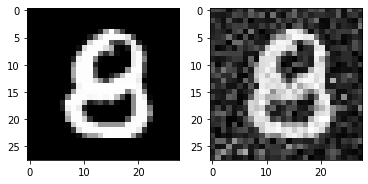

25  :  -0.35603313499079337 25
50  :  -0.35603313499079337 25
75  :  -0.3535887751095317 25
100  :  -0.34953306135818973 25
125  :  -0.3490787104213129 25
150  :  -0.3480838303225775 25
175  :  -0.3422341567049547 25
200  :  -0.3422341567049547 25
225  :  -0.34155450694522543 25
250  :  -0.34152336654967463 25
275  :  -0.338831342960511 25
300  :  -0.338831342960511 25
325  :  -0.338831342960511 25
350  :  -0.3377749335241993 25
375  :  -0.3367895338128764 25
400  :  -0.3367895338128764 25
425  :  -0.3367895338128764 25
450  :  -0.3358399989067826 25
475  :  -0.3358413184310526 25
500  :  -0.3358413184310526 25
525  :  -0.335532421543843 25
550  :  -0.33503964750965487 25
575  :  -0.33503964750965487 25
600  :  -0.3348312719625445 25
625  :  -0.3346631557619646 25
650  :  -0.3342775417470755 25
675  :  -0.3342776553981106 25
700  :  -0.3342566211748995 25
725  :  -0.3338518387582706 25
750  :  -0.3335594214609334 25
775  :  -0.33354007564464416 25
800  :  -0.3332493290702646 25
Time:  

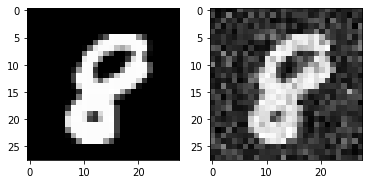

25  :  -0.3366544830711948 25
50  :  -0.3344935695806199 25
75  :  -0.3344935695806199 25
100  :  -0.3344935695806199 25
125  :  -0.3344935695806199 25
150  :  -0.3344935695806199 25
175  :  0.23644863708220723 25
200  :  0.30602033641542536 25
225  :  0.5812792543480771 25
250  :  0.6098254772499867 25
275  :  0.6016652678015859 25
300  :  0.6180581574595705 25
325  :  0.6192293723276772 25
350  :  0.6192293723276772 25
375  :  0.6192293723276772 25
400  :  0.6221623367629362 25
425  :  0.6230164086214489 25
450  :  0.6269987182421883 25
475  :  0.628287190111994 25
500  :  0.628287190111994 25
525  :  0.628606696650056 25
550  :  0.6285869536050344 25
575  :  0.6286209773953573 25
600  :  0.6305313324539094 25
625  :  0.6307943355250843 25
650  :  0.6308135818489815 25
675  :  0.6310300155849669 25
700  :  0.6313309181757591 25
725  :  0.6322173312449062 25
750  :  0.6322775361223308 25
775  :  0.6327291528510532 25
800  :  0.6327305934222004 25
825  :  0.6327305934222004 25
850  :  

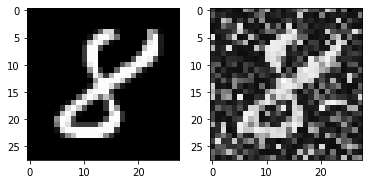

25  :  -0.3661309117095873 25
50  :  -0.3645327517580333 25
75  :  -0.361403784377313 25
100  :  -0.35507531245987123 25
125  :  -0.35507717984720066 25
150  :  -0.35180323417350945 25
175  :  -0.3506028810386636 25
200  :  -0.3456840718530382 25
225  :  -0.3456840718530382 25
250  :  -0.3456840718530382 25
275  :  -0.34508844373788394 25
300  :  -0.34507349681077837 25
325  :  -0.34455389102328005 25
350  :  -0.3426416315314791 25
375  :  -0.3426416315314791 25
400  :  -0.3426416315314791 25
425  :  -0.3424840974351571 25
450  :  -0.3424534111685102 25
475  :  -0.34226360683319584 25
500  :  -0.341882713430119 25
525  :  -0.34133225931704514 25
550  :  -0.34133225931704514 25
575  :  -0.3409461176988061 25
600  :  -0.34095346751647493 25
625  :  -0.34063702009118224 25
650  :  -0.34019693830847053 25
675  :  -0.3398348918043834 25
700  :  -0.3398348918043834 25
725  :  -0.3398348918043834 25
750  :  -0.3397325630714523 25
775  :  -0.33950218040034463 25
800  :  -0.339422005897916 25
T

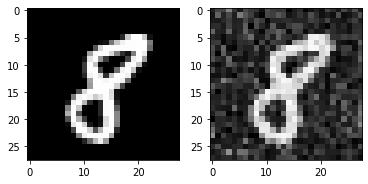

25  :  0.5993550047058399 25
50  :  0.6168013325848872 25
75  :  0.6080379796248739 25
100  :  0.6064940036506534 25
125  :  0.6064940036506534 25
150  :  0.6064940036506534 25
175  :  0.6065784228906458 25
200  :  0.6065784228906458 25
225  :  0.6096147339440922 25
250  :  0.6096147339440922 25
275  :  0.6096147339440922 25
300  :  0.6096147339440922 25
325  :  0.6096147339440922 25
350  :  0.610356622656502 25
375  :  0.6106416350491286 25
400  :  0.6106812756852812 25
425  :  0.615430436375246 25
450  :  0.615430436375246 25
475  :  0.615430436375246 25
500  :  0.6178374849538001 25
525  :  0.618260775138488 25
550  :  0.6179805277086731 25
575  :  0.6183171290343809 25
600  :  0.6183144020532827 25
625  :  0.6197610588414425 25
650  :  0.6198488907656367 25
675  :  0.6201555243402919 25
700  :  0.6213136183468971 25
725  :  0.6213112506503331 25
750  :  0.6213112506503331 25
775  :  0.6218527167641712 25
800  :  0.6223733351635337 25
825  :  0.6223733351635337 25
Time:  46.68987846

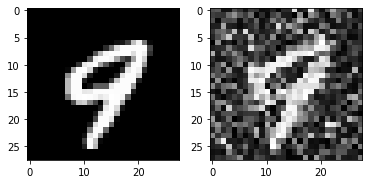

25  :  0.6081026379705103 25
50  :  0.6081026379705103 25
75  :  0.609711874231768 25
100  :  0.6114618669546391 25
125  :  0.6093730991035455 25
150  :  0.6093730991035455 25
175  :  0.6093730991035455 25
200  :  0.6093730991035455 25
225  :  0.6117921440952505 25
250  :  0.6117921440952505 25
275  :  0.6117921440952505 25
300  :  0.6117921440952505 25
325  :  0.6128158761670371 25
350  :  0.6132992269017898 25
375  :  0.6134783942573974 25
400  :  0.6152305556969505 25
425  :  0.6204205020252878 25
450  :  0.6204205020252878 25
475  :  0.6204205020252878 25
500  :  0.6204205020252878 25
525  :  0.6204205020252878 25
550  :  0.6237230539135526 25
575  :  0.623754234211123 25
600  :  0.623754234211123 25
625  :  0.623754234211123 25
650  :  0.6250732901703839 25
675  :  0.6250732901703839 25
700  :  0.6250732901703839 25
725  :  0.6250732901703839 25
750  :  0.6250732901703839 25
775  :  0.6263684534560807 25
800  :  0.6263684534560807 25
Time:  45.89094090461731  seconds
Predicted cla

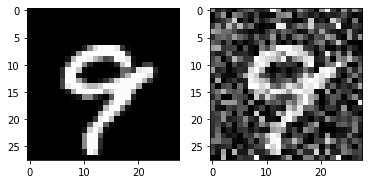

25  :  0.6009775603267266 25
50  :  0.6013806331508043 25
75  :  0.6009808822520681 25
100  :  0.6009808822520681 25
125  :  0.6036321837024685 25
150  :  0.6036321837024685 25
175  :  0.6039193738157628 25
200  :  0.6039064866463698 25
225  :  0.6039064866463698 25
250  :  0.6039064866463698 25
275  :  0.6039064866463698 25
300  :  0.6081884763576098 25
325  :  0.6082480658778153 25
350  :  0.6082480658778153 25
375  :  0.6094108009194481 25
400  :  0.6094224422133351 25
425  :  0.6094224422133351 25
450  :  0.6094224422133351 25
475  :  0.6122253473554701 25
500  :  0.6122253473554701 25
525  :  0.6122253473554701 25
550  :  0.6122253473554701 25
575  :  0.6122253473554701 25
600  :  0.6122253473554701 25
625  :  0.6138803528546034 25
650  :  0.6149680959675143 25
675  :  0.6149682802715442 25
700  :  0.6160407778219715 25
725  :  0.6160407778219715 25
750  :  0.6160407778219715 25
775  :  0.6168245316640684 25
800  :  0.6171987265801606 25
Time:  44.65801382064819  seconds
Predicted

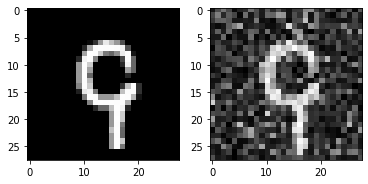

25  :  0.6100824382920298 25
50  :  0.6100824382920298 25
75  :  0.6097674212034188 25
100  :  0.608919905893082 25
125  :  0.6138643965976069 25
150  :  0.6093092966517608 25
175  :  0.6093092966517608 25
200  :  0.612328206805624 25
225  :  0.61390776206085 25
250  :  0.6153627117666569 25
275  :  0.6156133921660658 25
300  :  0.6177323721301883 25
325  :  0.6176453859355296 25
350  :  0.6182657661405928 25
375  :  0.6182657661405928 25
400  :  0.6211863348068662 25
425  :  0.6233854878612307 25
450  :  0.6234431668474142 25
475  :  0.6237268658042981 25
500  :  0.6274385749262084 25
525  :  0.6273488497146571 25
550  :  0.6273488497146571 25
575  :  0.6280316780109134 25
600  :  0.6280065791847363 25
625  :  0.6288060015029656 25
650  :  0.6302114395649344 25
675  :  0.6302114395649344 25
700  :  0.6308457520621811 25
725  :  0.6321500864669738 25
750  :  0.6321566213202869 25
775  :  0.6327749266093873 25
800  :  0.6331506319797383 25
Time:  44.8287456035614  seconds
Predicted clas

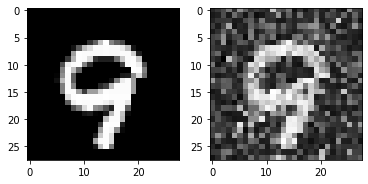

25  :  0.6145429204626802 25
50  :  0.6145429204626802 25
75  :  0.6209365573077545 25
100  :  0.6216652071504282 25
125  :  0.6210577988077995 25
150  :  0.6210577988077995 25
175  :  0.6210577988077995 25
200  :  0.6218263663088879 25
225  :  0.6218263663088879 25
250  :  0.6218263663088879 25
275  :  0.624794098446196 25
300  :  0.6246173554184862 25
325  :  0.6246173554184862 25
350  :  0.6246173554184862 25
375  :  0.6257552831667981 25
400  :  0.6260674288640652 25
425  :  0.6260674288640652 25
450  :  0.6286156288589394 25
475  :  0.6283660298308856 25
500  :  0.6283660298308856 25
525  :  0.6283660298308856 25
550  :  0.6283966606133923 25
575  :  0.6283966606133923 25
600  :  0.6298596745650774 25
625  :  0.6298596745650774 25
650  :  0.6321616247924744 25
675  :  0.6320960036535503 25
700  :  0.6355002353611862 25
725  :  0.6355002353611862 25
750  :  0.6355002353611862 25
775  :  0.6355002353611862 25
800  :  0.6355002353611862 25
Time:  44.666000843048096  seconds
Predicted

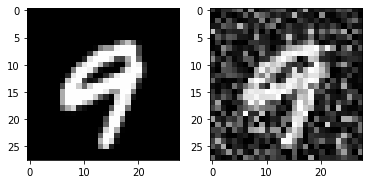

25  :  0.6153108606664902 25
50  :  0.6153108606664902 25
75  :  0.6153108606664902 25
100  :  0.6153108606664902 25
125  :  0.6153108606664902 25
150  :  0.6153108606664902 25
175  :  0.6153108606664902 25
200  :  0.6153108606664902 25
225  :  0.6154059855083793 25
250  :  0.6154059855083793 25
275  :  0.6161559745392277 25
300  :  0.6167750893397541 25
325  :  0.6176671073875798 25
350  :  0.619156109533025 25
375  :  0.6190039138401543 25
400  :  0.6210454691720895 25
425  :  0.6215976077745259 25
450  :  0.6215976077745259 25
475  :  0.622378402631767 25
500  :  0.622428650841332 25
525  :  0.6224150136404666 25
550  :  0.6225767013769523 25
575  :  0.6252953483145169 25
600  :  0.6252953483145169 25
625  :  0.6252953483145169 25
650  :  0.6252953483145169 25
675  :  0.6259149033141409 25
700  :  0.6278926199739477 25
725  :  0.6278926199739477 25
750  :  0.6278926199739477 25
775  :  0.6280295786739538 25
800  :  0.6287940559042551 25
Time:  44.50144910812378  seconds
Predicted cl

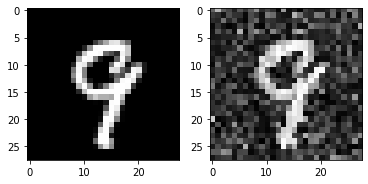

25  :  0.600046164963659 25
50  :  0.6014609382710294 25
75  :  0.6013476075799663 25
100  :  0.6002024407985679 25
125  :  0.6008161004583752 25
150  :  0.6008161004583752 25
175  :  0.6042550762149418 25
200  :  0.6042550762149418 25
225  :  0.6042550762149418 25
250  :  0.6042550762149418 25
275  :  0.6042550762149418 25
300  :  0.6045975445475177 25
325  :  0.6067231594948727 25
350  :  0.6067016966119978 25
375  :  0.6067016966119978 25
400  :  0.6067016966119978 25
425  :  0.6067016966119978 25
450  :  0.6067016966119978 25
475  :  0.6084409629448804 25
500  :  0.6087031279821303 25
525  :  0.6097997164072678 25
550  :  0.6109114889516086 25
575  :  0.6108105272679281 25
600  :  0.6108105272679281 25
625  :  0.611889743209004 25
650  :  0.611829206351782 25
675  :  0.612506154684403 25
700  :  0.612666542127612 25
725  :  0.6135632543746483 25
750  :  0.6138731103565487 25
775  :  0.6142306128710191 25
800  :  0.6145017343655237 25
Time:  45.306360483169556  seconds
Predicted cla

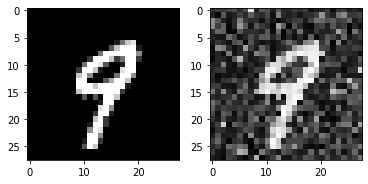

25  :  0.5945157645911875 25
50  :  0.5945157645911875 25
75  :  0.5954428440575168 25
100  :  0.5954428440575168 25
125  :  0.5954428440575168 25
150  :  0.5959438347645125 25
175  :  0.5987941832168677 25
200  :  0.5954745468482894 25
225  :  0.596292037827813 25
250  :  0.5961172338412665 25
275  :  0.5963096236559049 25
300  :  0.5968642682367454 25
325  :  0.597595391684739 25
350  :  0.5971983458561012 25
375  :  0.5971983458561012 25
400  :  0.6017392522195303 25
425  :  0.6016113078333922 25
450  :  0.6016113078333922 25
475  :  0.6016113078333922 25
500  :  0.6019129022064172 25
525  :  0.6019439857571994 25
550  :  0.6019439857571994 25
575  :  0.6019439857571994 25
600  :  0.6026723790490315 25
625  :  0.6026723790490315 25
650  :  0.6028462994357666 25
675  :  0.6027358495161833 25
700  :  0.6033012917408741 25
725  :  0.6040378282817138 25
750  :  0.6041325104513425 25
775  :  0.6047624811667722 25
800  :  0.6046229597973545 25
Time:  44.64594006538391  seconds
Predicted c

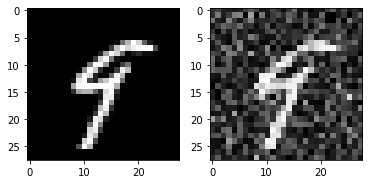

25  :  0.5998263219810689 25
50  :  0.5998263219810689 25
75  :  0.6091304550454113 25
100  :  0.6091304550454113 25
125  :  0.6091304550454113 25
150  :  0.6091304550454113 25
175  :  0.6091304550454113 25
200  :  0.6091304550454113 25
225  :  0.6107384675149256 25
250  :  0.609428096184734 25
275  :  0.609428096184734 25
300  :  0.611215768924246 25
325  :  0.6120795363682963 25
350  :  0.6120795363682963 25
375  :  0.6120795363682963 25
400  :  0.613093184990274 25
425  :  0.6129827620547967 25
450  :  0.6129827620547967 25
475  :  0.6153270125019327 25
500  :  0.6165971861917332 25
525  :  0.6165631475594593 25
550  :  0.6171176729398631 25
575  :  0.6185127603643676 25
600  :  0.620208695963747 25
625  :  0.6201115821538014 25
650  :  0.6211893877277361 25
675  :  0.6211893877277361 25
700  :  0.6212339108546979 25
725  :  0.6221432937262034 25
750  :  0.6221432937262034 25
775  :  0.6221432937262034 25
800  :  0.6228505567961699 25
Time:  45.70881748199463  seconds
Predicted clas

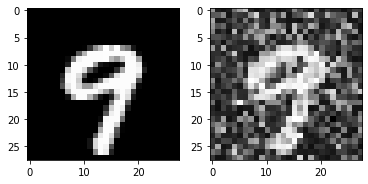

25  :  0.5834326937976293 25
50  :  0.5835049305956831 25
75  :  0.5873480422483323 25
100  :  0.5873480422483323 25
125  :  0.5873480422483323 25
150  :  0.5873480422483323 25
175  :  0.593176702055601 25
200  :  0.593176702055601 25
225  :  0.593176702055601 25
250  :  0.5942603311817921 25
275  :  0.5938894157496688 25
300  :  0.5938894157496688 25
325  :  0.5943493245213606 25
350  :  0.5949509781594082 25
375  :  0.5950097101120548 25
400  :  0.5951260036842329 25
425  :  0.5966187310718798 25
450  :  0.5971355377973002 25
475  :  0.5970722995570535 25
500  :  0.5970722995570535 25
525  :  0.5991305854496368 25
550  :  0.5991305854496368 25
575  :  0.5991305854496368 25
600  :  0.600881589256816 25
625  :  0.6008699799242182 25
650  :  0.6008699799242182 25
675  :  0.6008699799242182 25
700  :  0.6008699799242182 25
725  :  0.6012292551534166 25
750  :  0.6021605923685573 25
775  :  0.6024876654317156 25
800  :  0.6032109074834487 25
Time:  44.90120267868042  seconds
Predicted cla

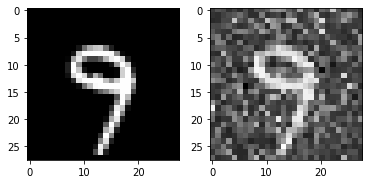

25  :  0.6267114983642613 25
50  :  0.6267114983642613 25
75  :  0.6286906903372915 25
100  :  0.6286906903372915 25
125  :  0.6303505388028823 25
150  :  0.6303505388028823 25
175  :  0.6308077362097211 25
200  :  0.6308077362097211 25
225  :  0.6325163639805721 25
250  :  0.6331298216266444 25
275  :  0.6348185288250483 25
300  :  0.6348185288250483 25
325  :  0.6349467506936816 25
350  :  0.6376032661550264 25
375  :  0.6382185635054278 25
400  :  0.6388537191230643 25
425  :  0.6409582303096342 25
450  :  0.6403572888114686 25
475  :  0.6415162346848843 25
500  :  0.6419989864587655 25
525  :  0.6423038771839428 25
550  :  0.6423038771839428 25
575  :  0.6437792107124974 25
600  :  0.644811048311583 25
625  :  0.6448147747243953 25
650  :  0.6452582079823731 25
675  :  0.6452632383496023 25
700  :  0.6465207347145419 25
725  :  0.6465154675411251 25
750  :  0.6476718324641938 25
775  :  0.6476736450858156 25
800  :  0.6484587774404121 25
Time:  44.66324210166931  seconds
Predicted 

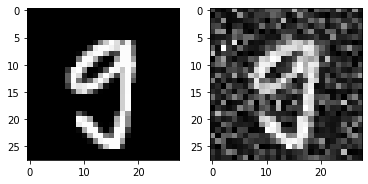

25  :  0.6024812086834259 25
50  :  0.6136992202180567 25
75  :  0.6086606919287713 25
100  :  0.614260309215924 25
125  :  0.614260309215924 25
150  :  0.6180576856387835 25
175  :  0.6188891395004268 25
200  :  0.6188891395004268 25
225  :  0.6188891395004268 25
250  :  0.6188891395004268 25
275  :  0.6188891395004268 25
300  :  0.6188891395004268 25
325  :  0.6188891395004268 25
350  :  0.6188891395004268 25
375  :  0.6188891395004268 25
400  :  0.6194729671361152 25
425  :  0.6210212341325017 25
450  :  0.6210371019721872 25
475  :  0.6222139887346088 25
500  :  0.623172941990939 25
525  :  0.6236360960482263 25
550  :  0.6242555217732403 25
575  :  0.6242555217732403 25
600  :  0.6248845032533663 25
625  :  0.6251480832858147 25
650  :  0.625592133198751 25
675  :  0.6260302228535223 25
700  :  0.6260302228535223 25
725  :  0.6260302228535223 25
750  :  0.6261512702737881 25
775  :  0.62663340501045 25
800  :  0.6270645029949155 25
825  :  0.6270664025039064 25
Time:  48.070630311

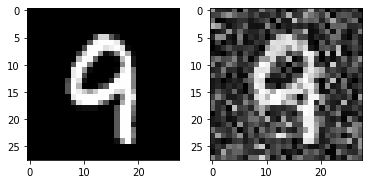

25  :  0.6131566907173176 25
50  :  0.6168516433228357 25
75  :  0.6188844838261172 25
100  :  0.619999221319696 25
125  :  0.6202671791741335 25
150  :  0.6202671791741335 25
175  :  0.6202671791741335 25
200  :  0.6211758785138375 25
225  :  0.6221374544286626 25
250  :  0.6220264581350239 25
275  :  0.6242362525383979 25
300  :  0.6265970116088017 25
325  :  0.6265970116088017 25
350  :  0.6265970116088017 25
375  :  0.6265970116088017 25
400  :  0.6265970116088017 25
425  :  0.6265970116088017 25
450  :  0.6265970116088017 25
475  :  0.6266402708622865 25
500  :  0.6271421465223483 25
525  :  0.6274428933286951 25
550  :  0.6289642454221311 25
575  :  0.6306129734376444 25
600  :  0.6306129734376444 25
625  :  0.6317798883844641 25
650  :  0.6317798883844641 25
675  :  0.6332897008822174 25
700  :  0.6333974669684744 25
725  :  0.6349000363765726 25
750  :  0.6353831730082544 25
775  :  0.6353831730082544 25
800  :  0.6353831730082544 25
Time:  45.45772647857666  seconds
Predicted 

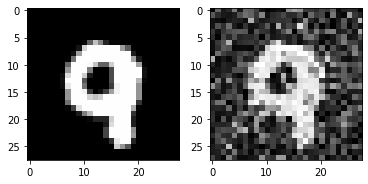

In [20]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28,28,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_cnn_mnist_ssim', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [22]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

60.51768779754639
44.47392821311951
49.30297637553442
4.124928488702949


In [23]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

1075
800
827.9761904761905
49.05932014840847


In [24]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

14.696494038776905
8.512067293471729
11.242580123566064
1.3809362364469269
